In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

import utils as ut
from IPython.display import display

In [2]:
with open('../config/algos_repo.json', 'r') as f:
    config = json.load(f)

In [3]:
df_seeds = None
df_sems = None
df_all = None

obj = config['resources']['structure_learning_algorithms']
for alg in obj:
    try:
        df = pd.read_csv(f'./results/sim/{alg}.csv')
    except:
        continue

    print(alg)
    params = list(obj[alg][0].keys())

    df_seed = ut.best_seeds(df, params)
    df_seed['id'] = df['id'].unique()[0]
    df_seeds = pd.concat([df_seeds, df_seed], ignore_index=True)

    df_sem = ut.best_sems(df, params)
    df_sem['id'] = df['id'].unique()[0]
    df_sems = pd.concat([df_sems, df_sem], ignore_index=True)

    df_def = ut.best_all(df, params)
    df_def['id'] = df['id'].unique()[0]
    df_all = pd.concat([df_all, df_def], ignore_index=True)

pcalg_pc
tetrad_fges
tetrad_fci
gcastle_ica_lingam
gcastle_anm
cdt_cam
gcastle_notears
gcastle_notears_nonlinear


In [4]:
bench_all = pd.read_csv('./results/sim/joint_benchmarks.csv', index_col=0)
df = ut.best_h(bench_all)
df_agg = df.groupby(['id', 'graph_p', 'graph_d', 'graph_type', 'data_sem', 'data_n'], as_index=False)['SHD_pattern'].agg(['mean', 'sem']).reset_index()

/home/damian/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (24,26,27,28,29,33,34,39,41,42,43,44,45,47,48,57,58,59,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Plots

In [5]:
df_agg_plt = df_agg.rename(columns={'mean': 'SHD'}).drop(columns=['sem'])
df_agg_plt['strategy'] = 'seed'

df_seeds_plt = df_seeds.rename(columns={'SHD_mean': 'SHD'}).drop(columns=['hyper_id', 'SHD_sem'])
df_seeds_plt['strategy'] = 'dgp'

df_sems_plt = df_sems.rename(columns={'SHD_mean': 'SHD'}).drop(columns=['SHD_sem'])
df_sems_plt['strategy'] = 'sem'

df_all_plt = df_all.rename(columns={'SHD_mean': 'SHD'}).drop(columns=['SHD_sem'])
df_all_plt['strategy'] = 'def'

In [6]:
#df_final = pd.concat([df_agg_plt, df_seeds_plt, df_sems_plt, df_all_plt], axis=0)
df_final = pd.concat([df_agg_plt, df_seeds_plt, df_all_plt], axis=0)

In [7]:
df_final['graph'] = df_final.apply(lambda x: f"{x['graph_type'].upper()}{x['graph_d']}", axis=1)

In [8]:
def select_1(df, s, n):
    if s == 'gumbel':
        return df.loc[(df['data_sem'] == s) & (df['data_n'] == n) & (df['id'] != 'anm')]
    else:
        return df.loc[(df['data_sem'] == s) & (df['data_n'] == n)]
    
def select_2(df, s, d):
    if s == 'gumbel':
        return df.loc[(df['data_sem'] == s) & (df['graph_d'] == d) & (df['id'] != 'anm')]
    else:
        return df.loc[(df['data_sem'] == s) & (df['graph_d'] == d)]

### p by gtd

SEM = gp, n = 200


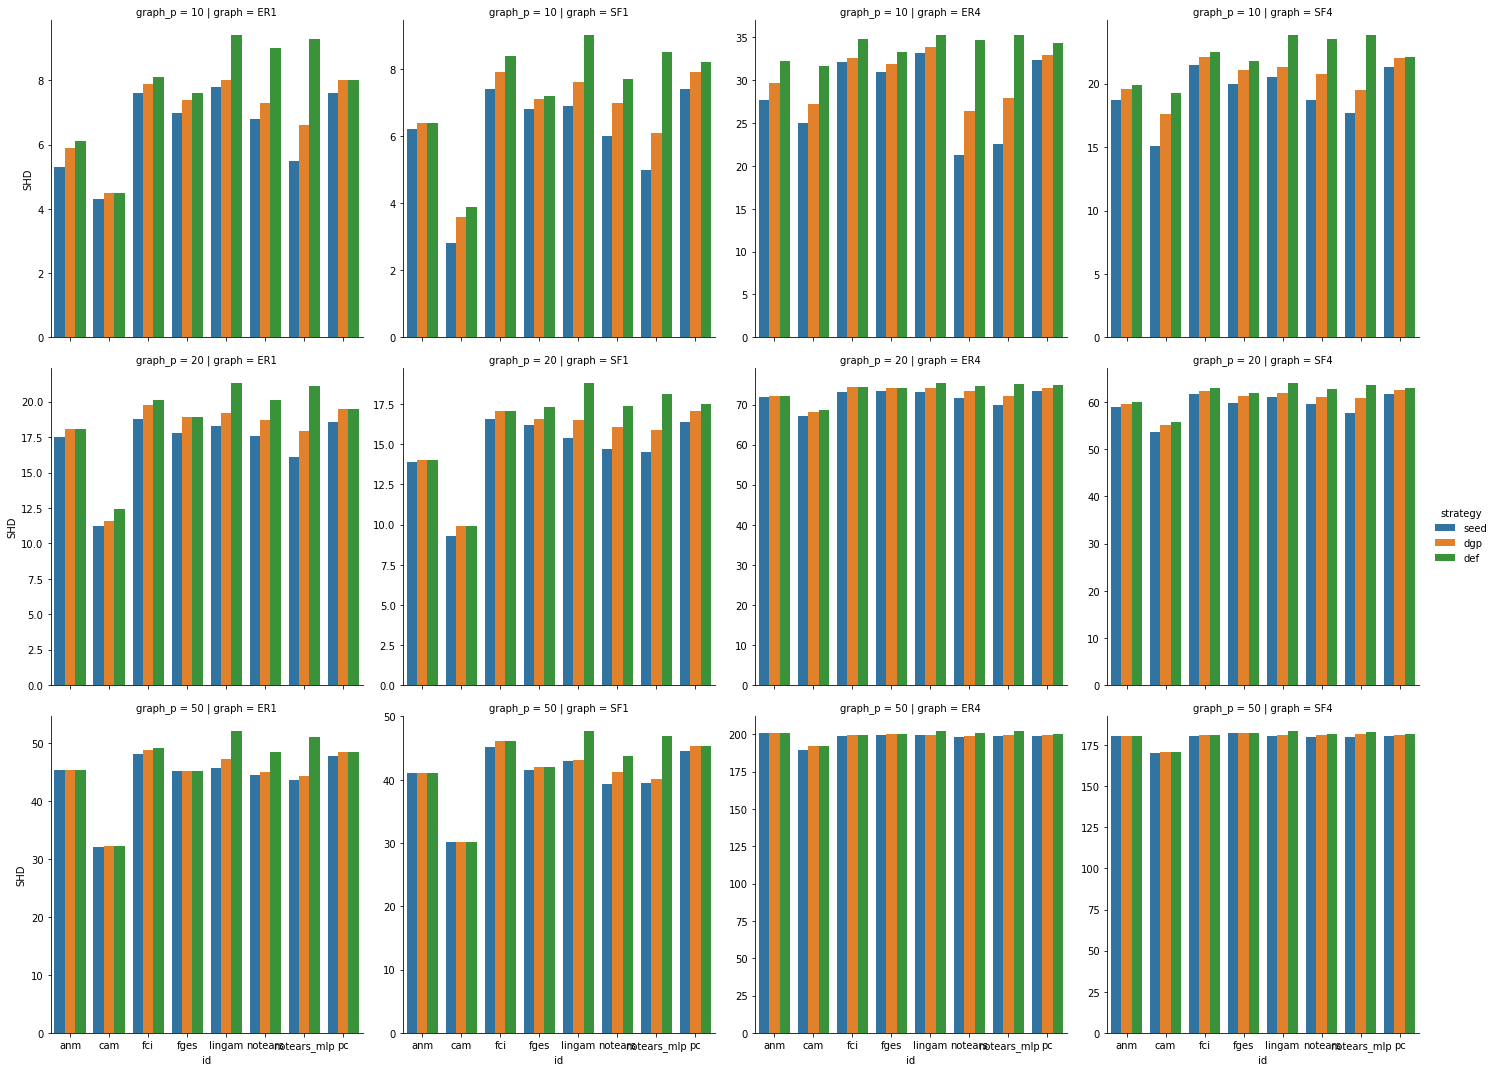

SEM = gp, n = 1000


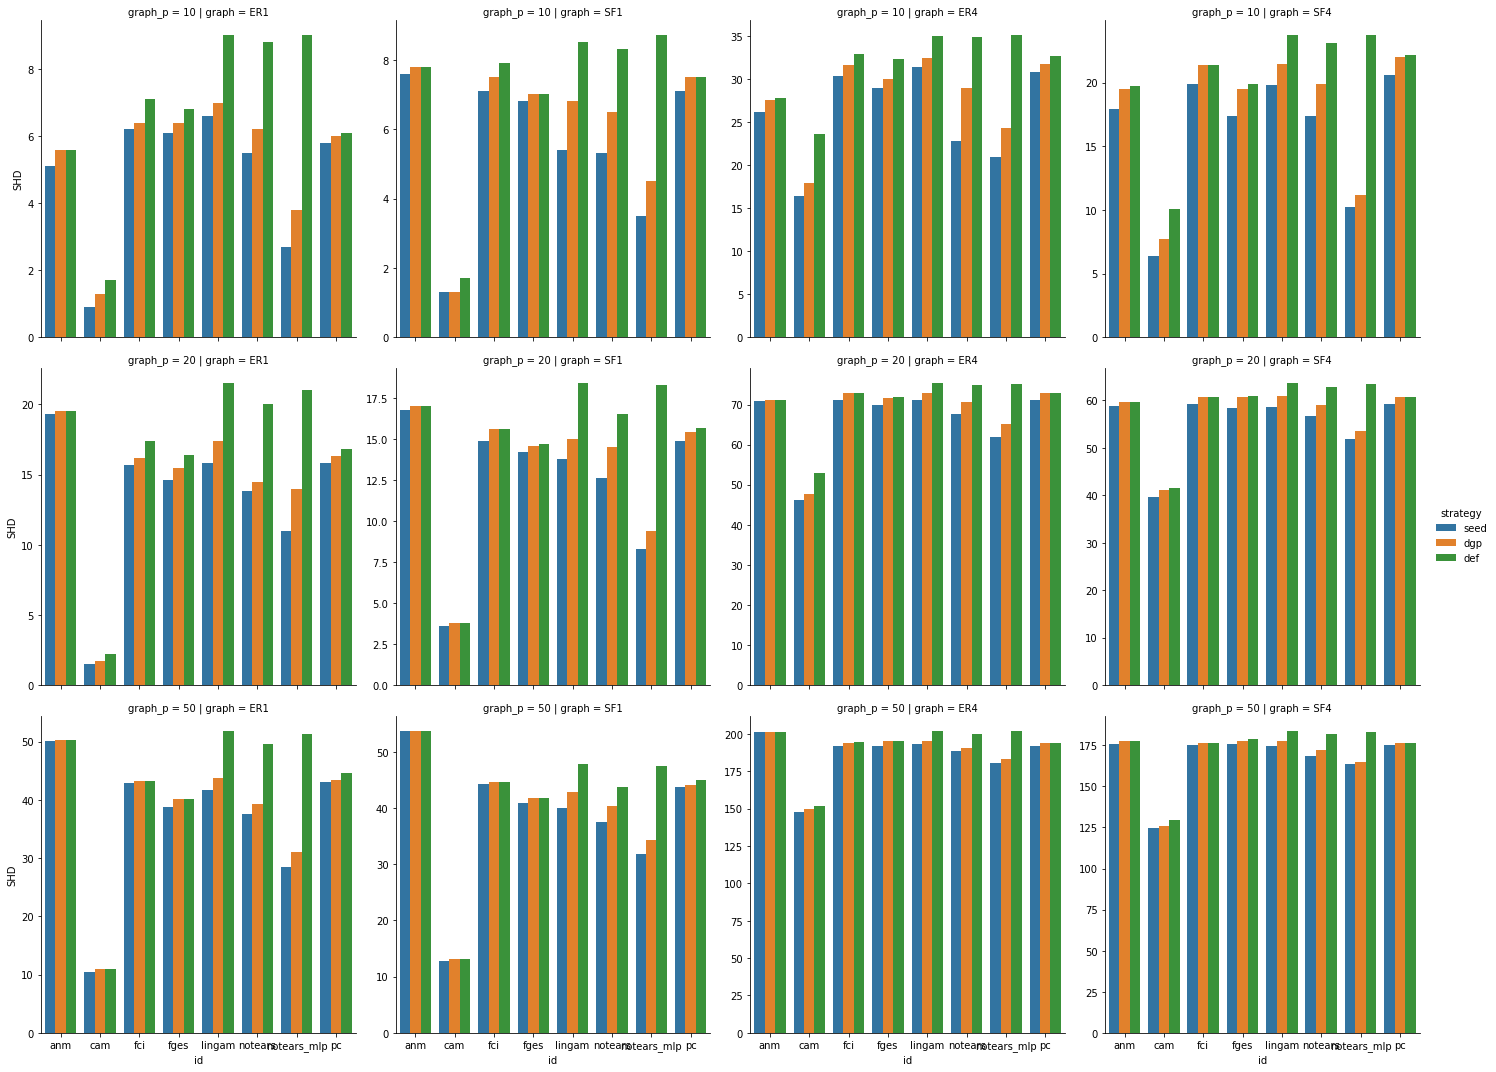

SEM = gumbel, n = 200


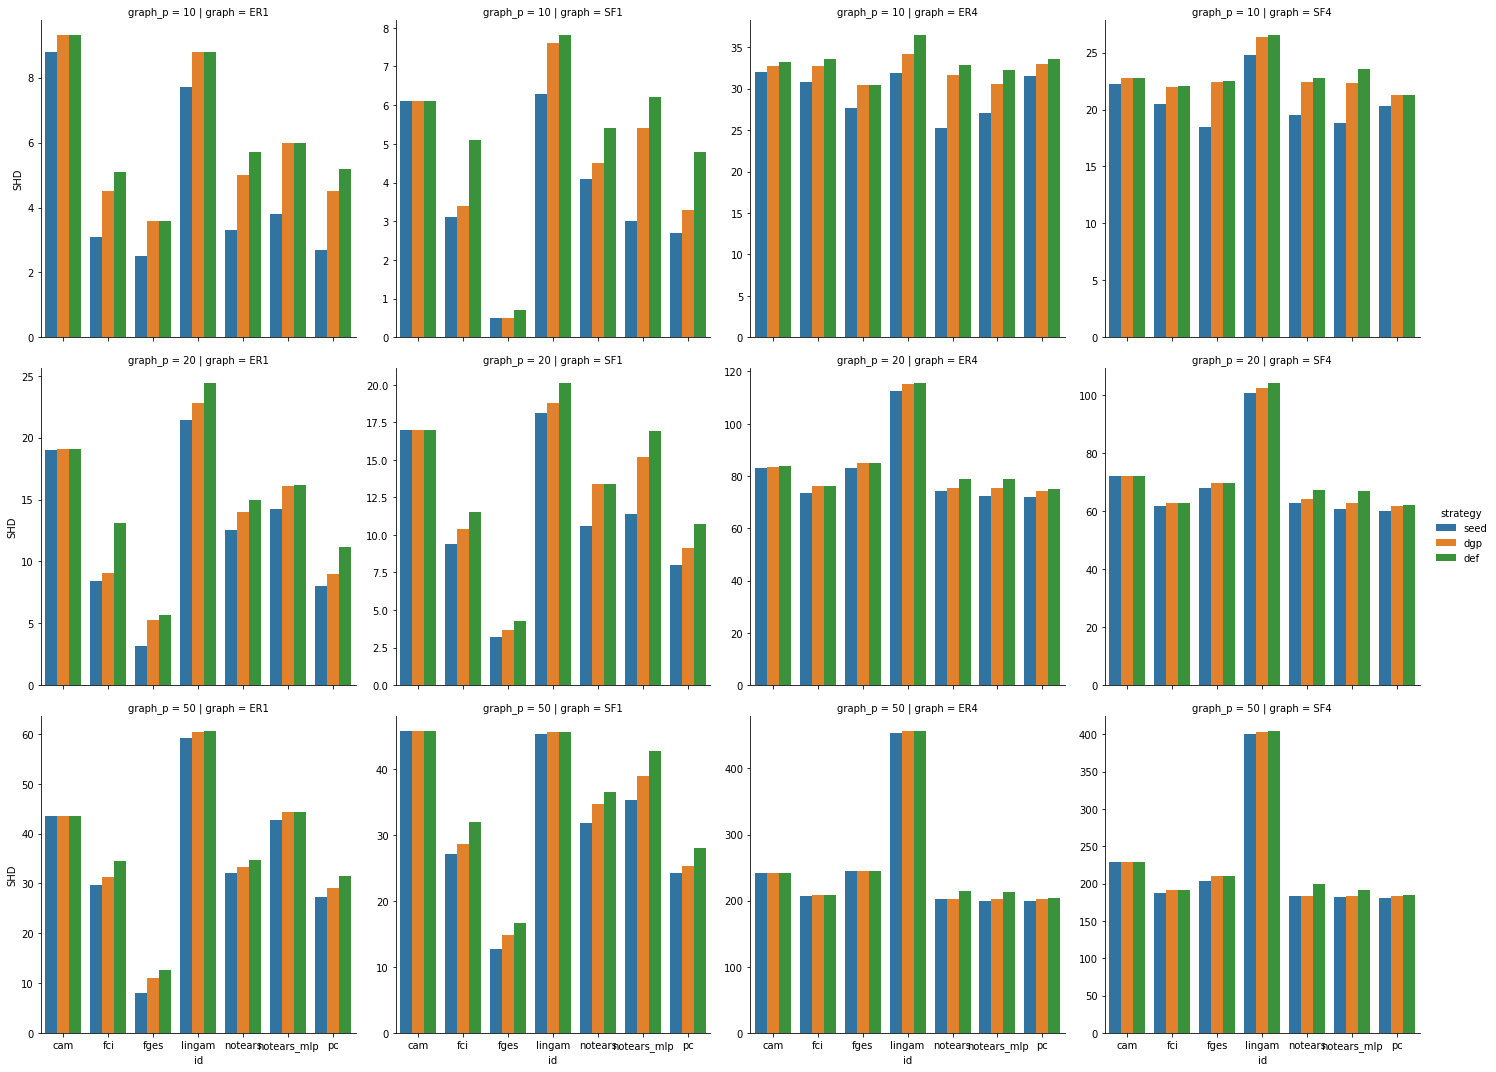

SEM = gumbel, n = 1000


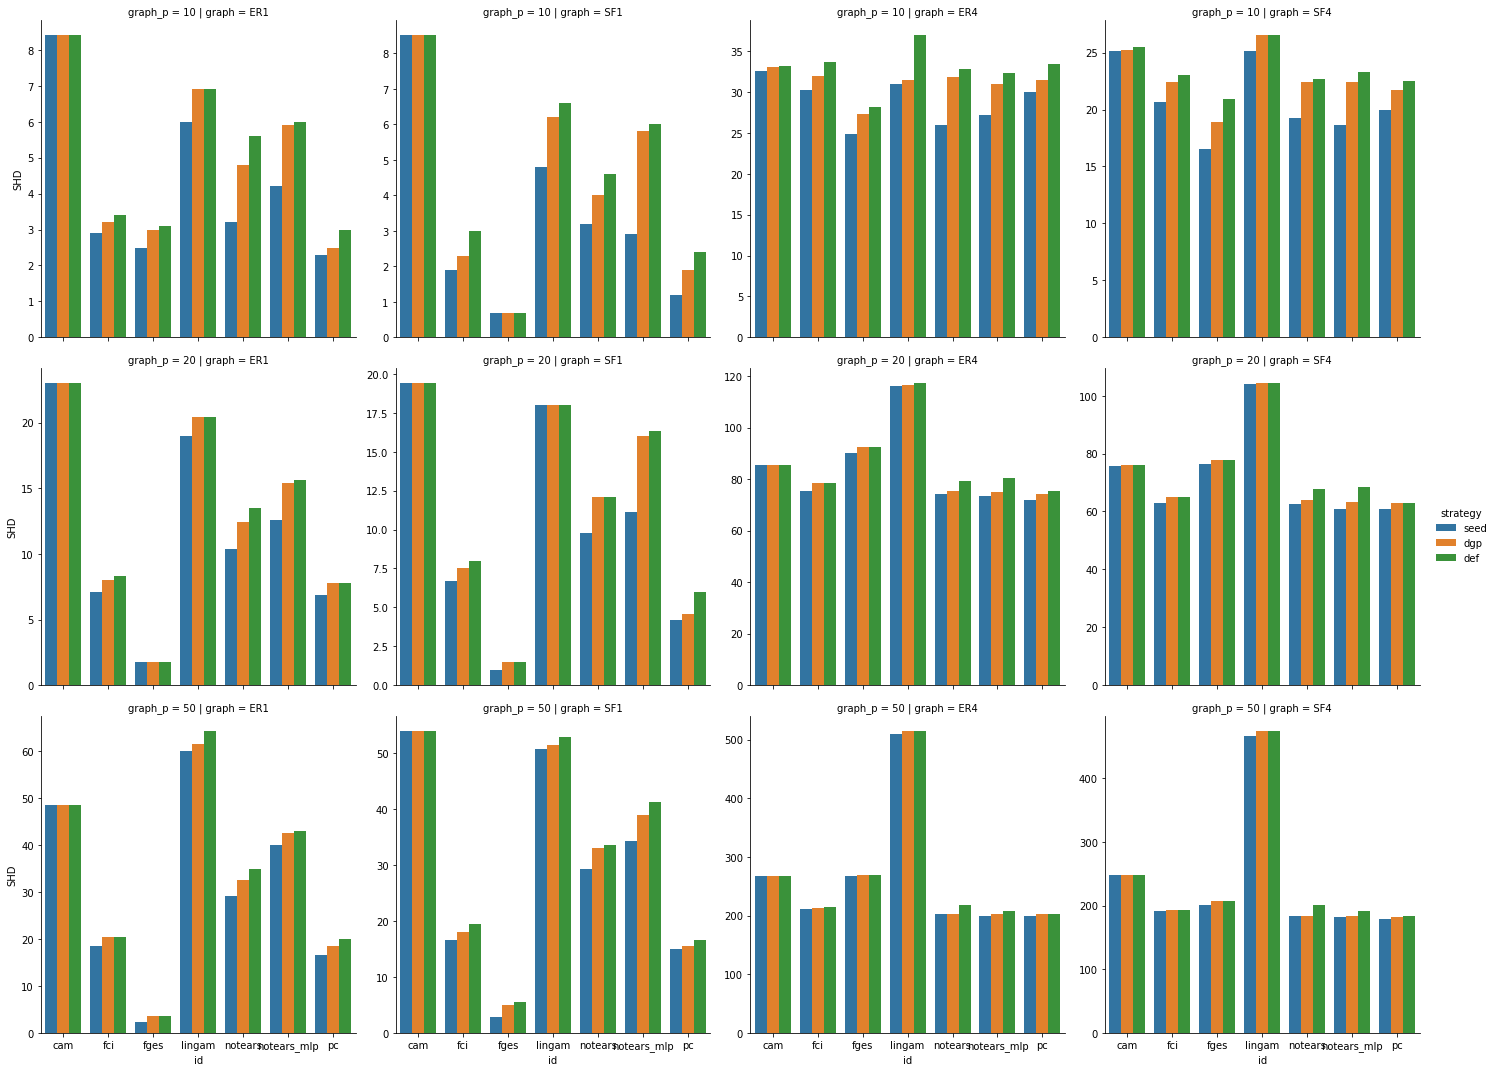

In [9]:
for sem in ['gp', 'gumbel']:
    for n in [200, 1000]:
        print(f'SEM = {sem}, n = {n}')
        df1 = select_1(df_final, sem, n)
        sns.catplot(data=df1, x='id', y='SHD', col='graph', row='graph_p', hue='strategy', kind='bar', ci=None, sharey=False)
        plt.show()

### p by (gtx, n)

SEM = gp, d = 1


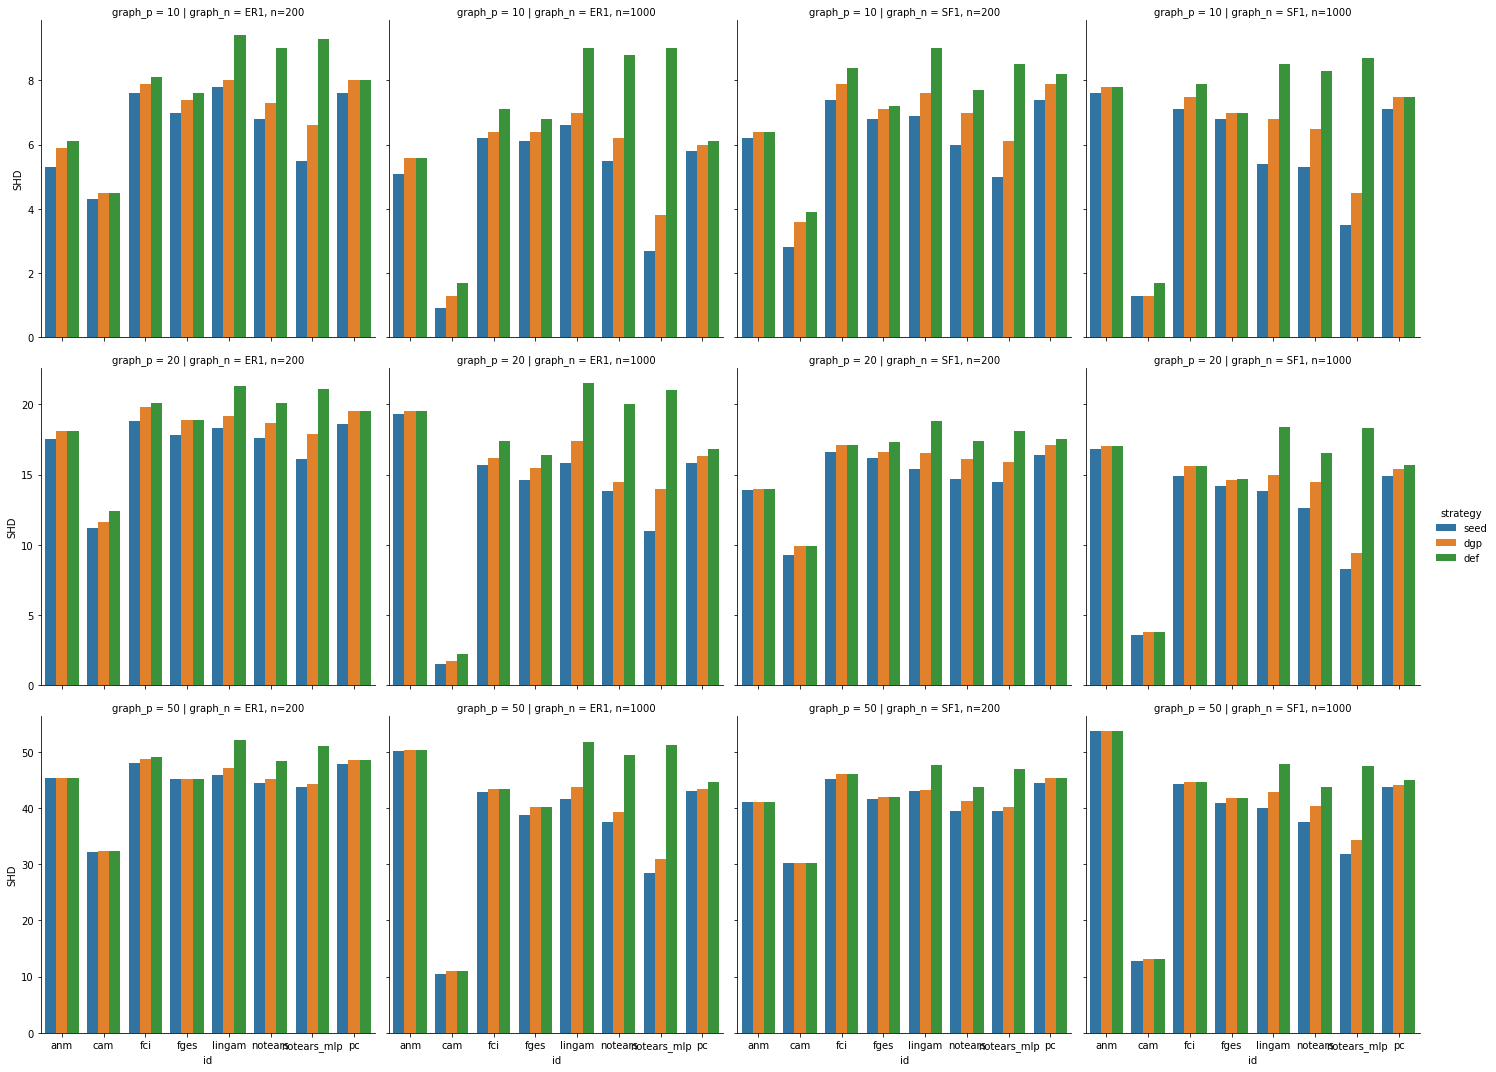

SEM = gp, d = 4


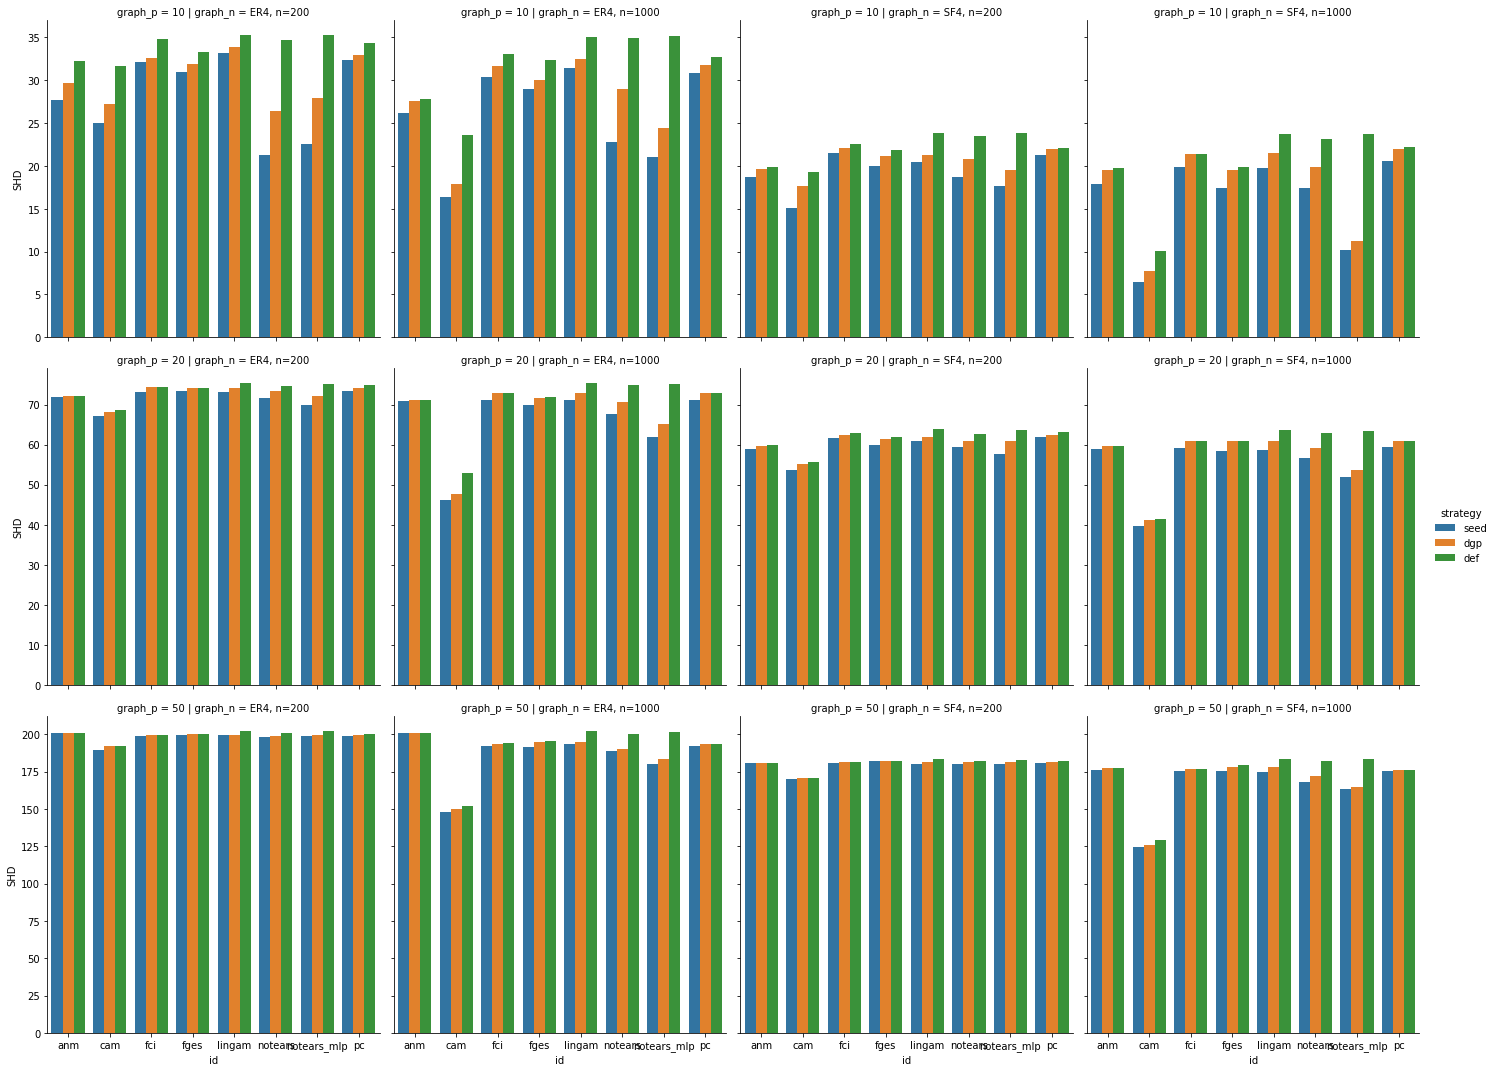

SEM = gumbel, d = 1


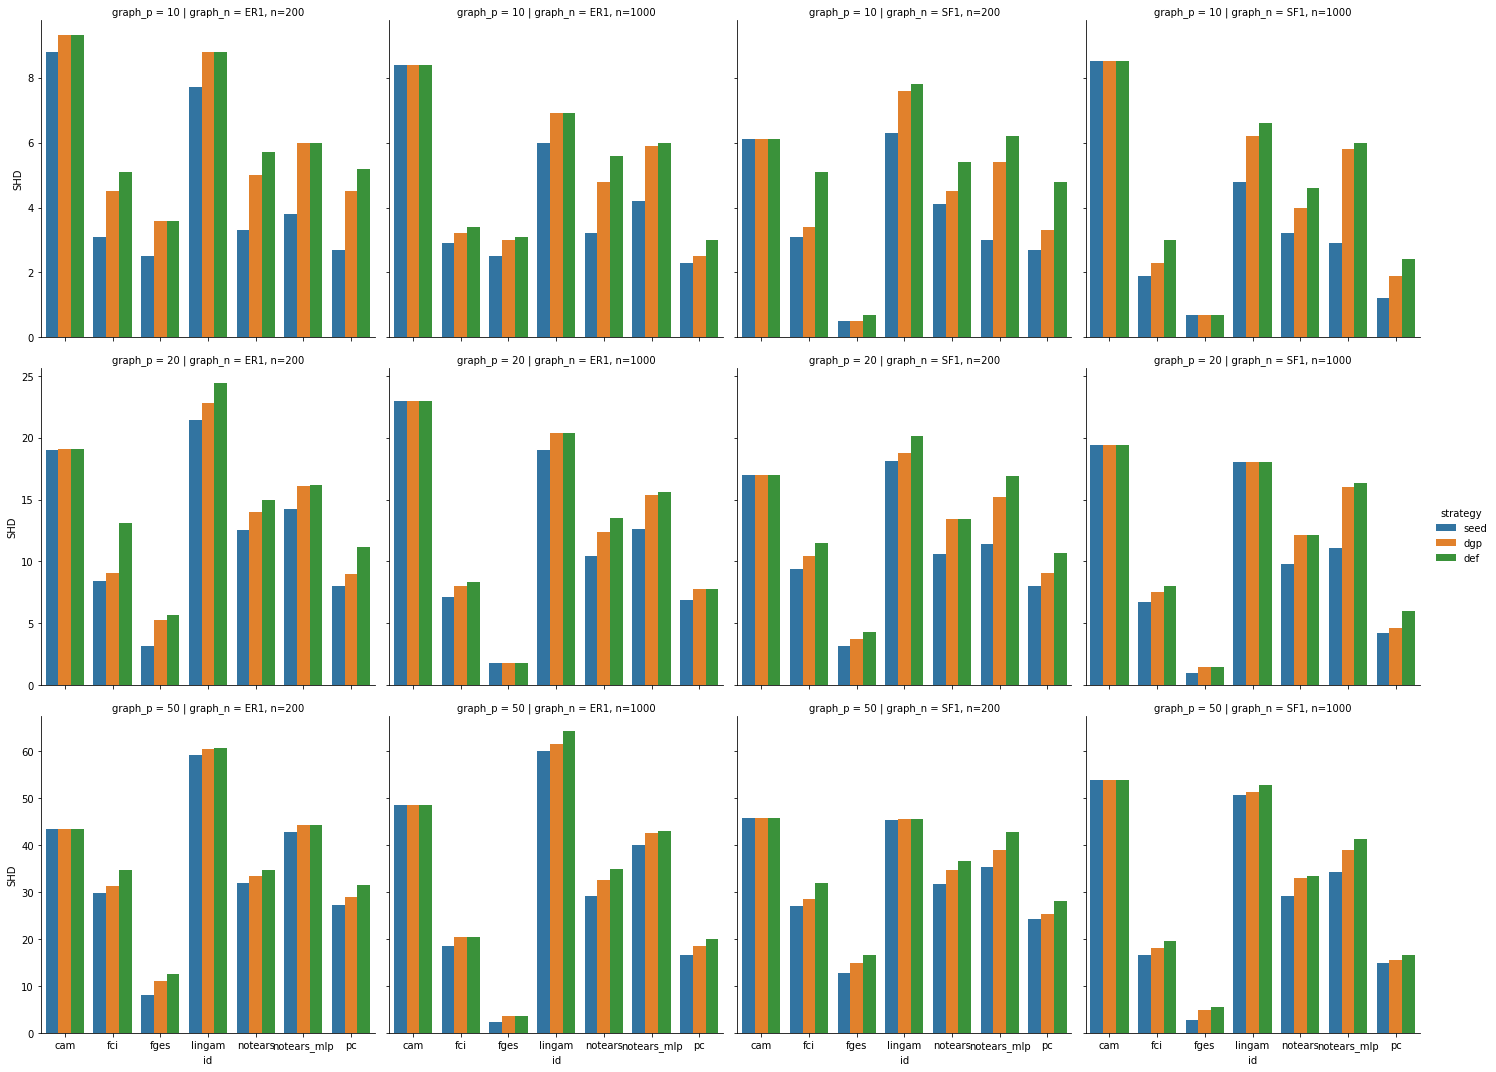

SEM = gumbel, d = 4


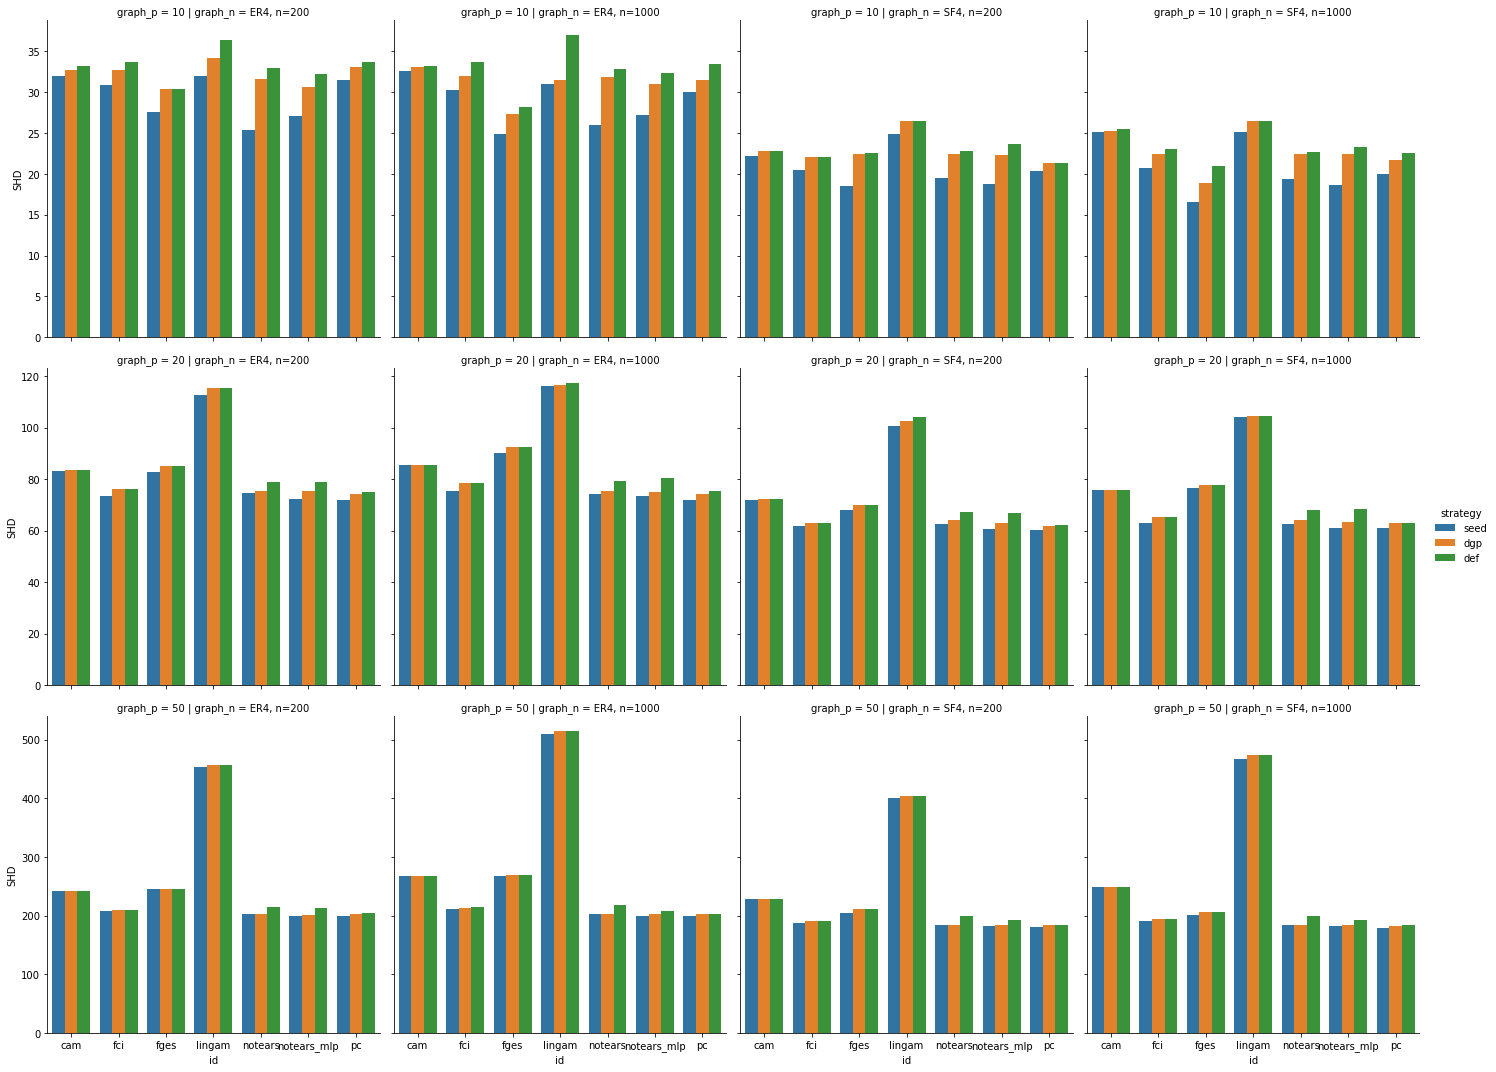

In [10]:
df_plt = df_final.copy()
df_plt['graph_n'] = df_plt.apply(lambda x: f"{x['graph']}, n={x['data_n']}", axis=1)

for sem in ['gp', 'gumbel']:
    for d in [1, 4]:
        print(f'SEM = {sem}, d = {d}')
        df1 = select_2(df_plt, sem, d)
        #sns.catplot(data=df1, x='id', y='SHD', col='graph_n', row='graph_p', hue='strategy', kind='bar', ci=None, sharey=True)
        sns.catplot(data=df1, x='id', y='SHD', col='graph_n', row='graph_p', hue='strategy', kind='bar', ci=None, sharey='row')
        plt.show()

## Tables

In [11]:
df_agg['seed'] = df_agg.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_agg.drop(columns=['sem'], inplace=True)
df_seeds['dgp'] = df_seeds.apply(lambda x: f"{x['SHD_mean']} ({x['SHD_sem']:.2f})", axis=1)
df_sems['sem'] = df_sems.apply(lambda x: f"{x['SHD_mean']} ({x['SHD_sem']:.2f})", axis=1)
df_all['def'] = df_all.apply(lambda x: f"{x['SHD_mean']} ({x['SHD_sem']:.2f})", axis=1)

In [12]:
merge_key = ['id', 'graph_p', 'graph_d', 'graph_type', 'data_sem', 'data_n']
#df_final = df_agg.merge(df_seeds, on=merge_key).merge(df_sems, on=merge_key).merge(df_all, on=merge_key)
df_final = df_agg.merge(df_seeds, on=merge_key).merge(df_all, on=merge_key)

df_final['graph_type_d'] = df_final.apply(lambda x: f"{x['graph_type'].upper()}{x['graph_d']}", axis=1)
df_final['id'] = df_final.apply(lambda x: x['id'].upper(), axis=1)

In [13]:
def select(df, gtd, p, sem, n):
    #return df.loc[(df['graph_type_d'] == gtd) & (df['data_sem'] == sem) & (df['data_n'] == n) & (df['graph_p'] == p), ['id', 'seed', 'dgp', 'sem', 'def']]
    return df.loc[(df['graph_type_d'] == gtd) & (df['data_sem'] == sem) & (df['data_n'] == n) & (df['graph_p'] == p), ['id', 'seed', 'dgp', 'def']]

def select_across_n(df, gt, d, p, sem):
    gtd = f'{gt.upper()}{d}'
    df1 = select(df, gtd, p, sem, 200).merge(select(df, gtd, p, sem, 1000), on='id', suffixes=['_200', '_1000'])

    df1.set_index('id', inplace=True)

    df1.columns = pd.MultiIndex.from_tuples([(f"n={c.split('_')[1]}", c.split('_')[0]) for c in df1.columns])

    return df1

def create_mi(df, p):
    return pd.MultiIndex.from_tuples([(p, c) for c in df.columns])

def select_across_p(df, gt, d, n, sem):
    gtd = f'{gt.upper()}{d}'
    df10 = select(df, gtd, 10, sem, n).set_index('id')
    df20 = select(df, gtd, 20, sem, n).set_index('id')
    df50 = select(df, gtd, 50, sem, n).set_index('id')

    for dfx, p in zip([df10, df20, df50], [10, 20, 50]):
        dfx.columns = create_mi(dfx, f'p={p}')

    return df10.merge(df20, on='id').merge(df50, on='id')

### Across 'n'

In [14]:
for gt in ['er', 'sf']:
    for d in [1, 4]:
        for sem in ['gumbel', 'gp']:
            for p in [10, 20, 50]:
                print()
                print('='*30)
                print(f"{gt.upper()}{d}, {sem}, p={p}")
                display(select_across_n(df_final, gt, d, p, sem))
                print()


ER1, gumbel, p=10


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          11.6 (1.41)  11.8 (1.37)  11.8 (1.37)  11.8 (1.78)  12.3 (1.78)   
CAM           8.8 (0.92)   9.3 (1.05)   9.3 (1.05)   8.4 (0.92)   8.4 (0.92)   
FCI           3.1 (0.82)   4.5 (0.93)   5.1 (0.94)   2.9 (0.92)   3.2 (1.04)   
FGES          2.5 (1.05)   3.6 (1.11)   3.6 (1.11)   2.5 (1.07)   3.0 (1.37)   
LINGAM        7.7 (1.31)   8.8 (1.44)   8.8 (1.44)   6.0 (1.58)   6.9 (1.54)   
NOTEARS       3.3 (0.45)   5.0 (0.56)   5.7 (0.76)   3.2 (0.71)   4.8 (0.95)   
NOTEARS_MLP   3.8 (0.66)   6.0 (1.03)   6.0 (1.03)   4.2 (0.65)   5.9 (1.11)   
PC            2.7 (0.79)   4.5 (0.76)   5.2 (0.89)   2.3 (0.79)   2.5 (0.86)   

                          
                     def  
id                        
ANM          12.3 (1.78)  
CAM           8.4 (0.92)  
FCI           3.4 (0.83)  
FGES          3.1 (1.35)  
LINGAM        6.9 (1.54)  
NOTEARS       5.6 (0.82)  
NOTEARS_MLP   6.0 (1.02)  
PC            3.0 (0.71)



ER1, gumbel, p=20


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          47.8 (5.87)  47.9 (5.90)  47.9 (5.90)  54.4 (7.62)  54.7 (7.61)   
CAM          19.0 (2.04)  19.1 (2.04)  19.1 (2.04)  23.0 (2.56)  23.0 (2.56)   
FCI           8.4 (1.11)   9.1 (1.17)  13.1 (1.78)   7.1 (1.67)   8.0 (1.69)   
FGES          3.2 (1.06)   5.3 (1.46)   5.7 (1.74)   1.8 (0.90)   1.8 (0.90)   
LINGAM       21.4 (1.33)  22.8 (1.87)  24.4 (1.83)  19.0 (2.12)  20.4 (2.38)   
NOTEARS      12.5 (1.75)  14.0 (1.93)  15.0 (1.81)  10.4 (1.87)  12.4 (2.33)   
NOTEARS_MLP  14.2 (1.09)  16.1 (1.41)  16.2 (1.37)  12.6 (1.42)  15.4 (1.59)   
PC            8.0 (0.91)   9.0 (1.21)  11.2 (1.50)   6.9 (1.45)   7.8 (1.44)   

                          
                     def  
id                        
ANM          54.7 (7.61)  
CAM          23.0 (2.56)  
FCI           8.3 (1.81)  
FGES          1.8 (0.90)  
LINGAM       20.4 (2.38)  
NOTEARS      13.5 (1.65)  
NOTEARS_MLP  15.6 (1.67)  
PC            7.8 (1.44)



ER1, gumbel, p=50


n=200                                       n=1000  \
                      seed            dgp            def           seed   
id                                                                        
ANM          155.2 (15.38)  155.2 (15.38)  155.2 (15.38)  200.3 (23.35)   
CAM            43.5 (4.81)    43.5 (4.81)    43.5 (4.81)    48.6 (4.10)   
FCI            29.7 (1.56)    31.2 (1.72)    34.6 (2.02)    18.6 (2.30)   
FGES            8.1 (1.21)    11.0 (1.21)    12.6 (1.61)     2.4 (0.90)   
LINGAM         59.1 (4.20)    60.4 (4.29)    60.6 (4.19)    60.0 (3.65)   
NOTEARS        32.0 (3.22)    33.4 (3.31)    34.8 (2.81)    29.2 (3.04)   
NOTEARS_MLP    42.8 (2.47)    44.3 (2.24)    44.3 (2.24)    40.1 (2.08)   
PC             27.3 (1.09)    29.0 (1.45)    31.4 (1.45)    16.6 (2.66)   

                                           
                       dgp            def  
id                                         
ANM          200.4 (23.37)  200.4 (23.37)  
CAM            48.6 (4.10)    48.6 (4.10)  
FCI            20.5 (2.38)    20.5 (2.38)  
FGES            3.5 (1.11)     3.5 (1.11)  
LINGAM         61.5 (3.94)    64.3 (3.43)  
NOTEARS        32.6 (2.75)    34.9 (2.79)  
NOTEARS_MLP    42.6 (2.37)    42.9 (2.12)  
PC             18.6 (2.64)    19.9 (3.01)



ER1, gp, p=10


n=200                              n=1000              \
                   seed         dgp         def        seed         dgp   
id                                                                        
ANM          5.3 (0.79)  5.9 (0.66)  6.1 (0.72)  5.1 (0.71)  5.6 (0.85)   
CAM          4.3 (1.01)  4.5 (1.00)  4.5 (1.00)  0.9 (0.38)  1.3 (0.54)   
FCI          7.6 (0.76)  7.9 (0.75)  8.1 (0.78)  6.2 (0.59)  6.4 (0.60)   
FGES         7.0 (0.77)  7.4 (0.78)  7.6 (0.73)  6.1 (0.69)  6.4 (0.64)   
LINGAM       7.8 (0.76)  8.0 (0.80)  9.4 (0.67)  6.6 (0.56)  7.0 (0.58)   
NOTEARS      6.8 (0.57)  7.3 (0.68)  9.0 (0.67)  5.5 (0.65)  6.2 (0.65)   
NOTEARS_MLP  5.5 (0.64)  6.6 (0.90)  9.3 (0.72)  2.7 (0.54)  3.8 (0.84)   
PC           7.6 (0.76)  8.0 (0.77)  8.0 (0.77)  5.8 (0.55)  6.0 (0.58)   

                         
                    def  
id                       
ANM          5.6 (0.85)  
CAM          1.7 (0.65)  
FCI          7.1 (0.77)  
FGES         6.8 (0.57)  
LINGAM       9.0 (0.70)  
NOTEARS      8.8 (0.71)  
NOTEARS_MLP  9.0 (0.70)  
PC           6.1 (0.64)



ER1, gp, p=20


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          17.5 (1.22)  18.1 (1.22)  18.1 (1.22)  19.3 (1.32)  19.5 (1.28)   
CAM          11.2 (0.92)  11.6 (0.83)  12.4 (0.87)   1.5 (0.52)   1.7 (0.52)   
FCI          18.8 (1.06)  19.8 (1.25)  20.1 (1.13)  15.7 (1.15)  16.2 (1.18)   
FGES         17.8 (1.35)  18.9 (0.94)  18.9 (1.30)  14.6 (1.24)  15.5 (1.20)   
LINGAM       18.3 (1.08)  19.2 (1.25)  21.3 (1.15)  15.8 (1.09)  17.4 (0.88)   
NOTEARS      17.6 (1.08)  18.7 (1.11)  20.1 (1.06)  13.8 (1.11)  14.5 (1.10)   
NOTEARS_MLP  16.1 (1.02)  17.9 (1.13)  21.1 (1.09)  11.0 (1.02)  14.0 (1.50)   
PC           18.6 (1.06)  19.5 (1.19)  19.5 (1.19)  15.8 (1.06)  16.3 (1.18)   

                          
                     def  
id                        
ANM          19.5 (1.28)  
CAM           2.2 (0.74)  
FCI          17.4 (0.90)  
FGES         16.4 (1.05)  
LINGAM       21.5 (1.01)  
NOTEARS      20.0 (1.07)  
NOTEARS_MLP  21.0 (0.95)  
PC           16.8 (0.98)



ER1, gp, p=50


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          45.4 (2.07)  45.4 (2.07)  45.4 (2.07)  50.1 (3.01)  50.3 (3.05)   
CAM          32.1 (2.35)  32.3 (2.34)  32.3 (2.34)  10.5 (1.05)  11.0 (1.01)   
FCI          48.1 (2.44)  48.8 (2.56)  49.1 (2.43)  42.9 (2.75)  43.3 (2.67)   
FGES         45.2 (2.37)  45.2 (2.37)  45.2 (2.37)  38.8 (2.66)  40.2 (2.75)   
LINGAM       45.8 (2.57)  47.2 (2.76)  52.1 (2.30)  41.6 (2.70)  43.8 (3.08)   
NOTEARS      44.5 (2.32)  45.1 (2.20)  48.4 (2.48)  37.5 (2.85)  39.3 (3.11)   
NOTEARS_MLP  43.7 (2.20)  44.3 (2.12)  51.0 (2.37)  28.5 (2.56)  31.0 (2.38)   
PC           47.8 (2.31)  48.5 (2.43)  48.5 (2.43)  43.1 (2.77)  43.4 (2.67)   

                          
                     def  
id                        
ANM          50.3 (3.05)  
CAM          11.0 (1.01)  
FCI          43.3 (2.67)  
FGES         40.2 (2.75)  
LINGAM       51.8 (2.24)  
NOTEARS      49.5 (2.20)  
NOTEARS_MLP  51.3 (2.26)  
PC           44.6 (2.82)



ER4, gumbel, p=10


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          29.1 (2.69)  30.2 (2.72)  30.5 (2.58)  27.5 (2.48)  30.0 (2.70)   
CAM          32.0 (1.16)  32.7 (1.19)  33.2 (1.01)  32.5 (0.93)  33.1 (0.85)   
FCI          30.8 (0.68)  32.7 (0.94)  33.6 (0.86)  30.2 (0.59)  32.0 (1.06)   
FGES         27.6 (1.09)  30.4 (0.99)  30.4 (0.99)  24.9 (1.83)  27.3 (1.77)   
LINGAM       31.9 (1.95)  34.2 (2.06)  36.4 (1.63)  31.0 (2.56)  31.5 (2.58)   
NOTEARS      25.3 (1.97)  31.6 (0.97)  32.9 (0.59)  25.9 (1.75)  31.8 (0.90)   
NOTEARS_MLP  27.1 (1.35)  30.6 (1.78)  32.2 (0.76)  27.2 (1.30)  31.0 (1.83)   
PC           31.5 (0.85)  33.0 (0.76)  33.6 (0.87)  30.0 (0.75)  31.5 (0.64)   

                          
                     def  
id                        
ANM          30.0 (2.70)  
CAM          33.2 (0.85)  
FCI          33.6 (0.70)  
FGES         28.2 (1.95)  
LINGAM       36.9 (1.63)  
NOTEARS      32.8 (0.51)  
NOTEARS_MLP  32.3 (0.83)  
PC           33.4 (0.73)



ER4, gumbel, p=20


n=200                                    n=1000  \
                     seed           dgp           def          seed   
id                                                                    
ANM          143.2 (1.72)  147.0 (2.24)  153.6 (3.61)  128.4 (5.82)   
CAM           83.1 (1.77)   83.6 (1.88)   83.7 (1.84)   85.5 (1.87)   
FCI           73.5 (2.67)   76.0 (3.01)   76.0 (3.01)   75.5 (2.84)   
FGES          82.9 (3.27)   85.1 (3.36)   85.1 (3.36)   90.1 (3.61)   
LINGAM       112.6 (2.84)  115.3 (3.28)  115.5 (2.86)  116.2 (3.58)   
NOTEARS       74.4 (2.54)   75.4 (2.30)   79.0 (2.85)   74.1 (2.39)   
NOTEARS_MLP   72.4 (2.67)   75.3 (2.30)   78.7 (2.58)   73.4 (2.29)   
PC            71.8 (2.91)   74.1 (2.64)   75.0 (3.33)   71.8 (2.53)   

                                         
                      dgp           def  
id                                       
ANM          128.4 (5.82)  161.1 (2.85)  
CAM           85.5 (1.87)   85.5 (1.87)  
FCI           78.6 (2.60)   78.6 (2.60)  
FGES          92.3 (3.62)   92.3 (3.62)  
LINGAM       116.6 (3.56)  117.2 (3.81)  
NOTEARS       75.4 (2.30)   79.1 (2.67)  
NOTEARS_MLP   75.1 (2.29)   80.5 (2.30)  
PC            74.2 (2.26)   75.3 (2.72)



ER4, gumbel, p=50


n=200                                       n=1000  \
                      seed            dgp            def           seed   
id                                                                        
ANM          777.6 (30.79)  781.3 (32.50)  781.3 (32.50)  841.7 (18.44)   
CAM           241.9 (7.28)   241.9 (7.28)   241.9 (7.28)   267.3 (9.44)   
FCI           207.4 (6.47)   208.8 (6.49)   208.8 (6.49)   211.3 (6.74)   
FGES         245.3 (11.14)  245.3 (11.14)  245.3 (11.14)  268.0 (15.92)   
LINGAM       453.9 (20.24)  456.5 (19.85)  456.5 (19.85)  509.8 (21.66)   
NOTEARS       202.1 (4.87)   202.2 (4.87)   215.3 (5.91)   202.1 (4.87)   
NOTEARS_MLP   199.1 (5.26)   201.8 (5.01)   212.5 (5.55)   199.9 (5.28)   
PC            199.7 (5.85)   202.2 (5.77)   204.3 (5.79)   199.5 (6.02)   

                                           
                       dgp            def  
id                                         
ANM          849.6 (18.78)  931.9 (25.16)  
CAM           267.4 (9.42)   267.4 (9.42)  
FCI           213.3 (7.07)   214.5 (7.07)  
FGES         268.7 (15.97)  268.7 (15.97)  
LINGAM       514.7 (20.94)  514.7 (20.94)  
NOTEARS       202.2 (4.87)   217.4 (5.42)  
NOTEARS_MLP   202.0 (4.86)   207.7 (4.81)  
PC            201.9 (6.28)   201.9 (6.28)



ER4, gp, p=10


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          27.7 (0.98)  29.7 (1.08)  32.2 (0.98)  26.2 (1.13)  27.6 (1.21)   
CAM          25.0 (1.03)  27.2 (1.49)  31.6 (1.10)  16.4 (1.28)  17.9 (1.26)   
FCI          32.1 (1.00)  32.6 (0.96)  34.8 (0.77)  30.4 (0.72)  31.7 (0.93)   
FGES         30.9 (0.97)  31.9 (1.06)  33.3 (0.92)  29.0 (0.75)  30.0 (0.71)   
LINGAM       33.2 (0.80)  33.9 (0.78)  35.2 (0.80)  31.4 (0.75)  32.5 (0.76)   
NOTEARS      21.3 (1.51)  26.4 (2.02)  34.7 (0.88)  22.8 (1.57)  29.0 (1.39)   
NOTEARS_MLP  22.5 (1.61)  27.9 (1.15)  35.2 (0.80)  21.0 (1.71)  24.4 (2.36)   
PC           32.3 (1.00)  32.9 (0.94)  34.3 (0.70)  30.8 (0.77)  31.8 (0.92)   

                          
                     def  
id                        
ANM          27.8 (1.15)  
CAM          23.6 (1.20)  
FCI          33.0 (0.84)  
FGES         32.4 (0.82)  
LINGAM       35.0 (0.80)  
NOTEARS      34.9 (0.91)  
NOTEARS_MLP  35.1 (0.84)  
PC           32.7 (1.00)



ER4, gp, p=20


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          71.8 (2.37)  72.2 (2.43)  72.2 (2.43)  70.9 (1.56)  71.1 (1.58)   
CAM          67.1 (2.66)  68.2 (2.64)  68.7 (2.54)  46.2 (3.00)  47.8 (2.93)   
FCI          73.2 (2.40)  74.3 (2.29)  74.4 (2.41)  71.1 (2.47)  72.8 (2.54)   
FGES         73.4 (2.53)  74.0 (2.50)  74.2 (2.50)  69.8 (2.89)  71.5 (2.87)   
LINGAM       73.0 (2.27)  74.2 (2.27)  75.3 (2.31)  71.0 (2.36)  72.9 (2.36)   
NOTEARS      71.7 (2.18)  73.3 (2.15)  74.7 (2.36)  67.6 (2.81)  70.7 (3.12)   
NOTEARS_MLP  69.8 (2.83)  72.1 (2.56)  75.2 (2.33)  61.9 (2.86)  65.1 (2.93)   
PC           73.4 (2.38)  74.1 (2.35)  74.8 (2.41)  71.0 (2.49)  72.8 (2.50)   

                          
                     def  
id                        
ANM          71.1 (1.58)  
CAM          52.9 (2.55)  
FCI          72.9 (2.36)  
FGES         71.9 (2.58)  
LINGAM       75.3 (2.28)  
NOTEARS      74.9 (2.28)  
NOTEARS_MLP  75.2 (2.31)  
PC           72.9 (2.31)



ER4, gp, p=50


n=200                                    n=1000  \
                     seed           dgp           def          seed   
id                                                                    
ANM          200.7 (5.06)  200.7 (5.06)  200.7 (5.06)  200.9 (5.86)   
CAM          189.7 (6.18)  192.3 (5.83)  192.3 (5.83)  147.8 (5.11)   
FCI          198.9 (5.39)  199.3 (5.25)  199.3 (5.25)  191.9 (5.70)   
FGES         199.6 (5.19)  199.9 (5.14)  199.9 (5.14)  191.5 (6.21)   
LINGAM       199.3 (5.10)  199.7 (5.12)  202.1 (4.87)  193.3 (5.48)   
NOTEARS      197.8 (5.17)  199.0 (5.02)  200.6 (4.88)  188.7 (5.79)   
NOTEARS_MLP  198.7 (5.15)  199.6 (5.20)  201.8 (4.88)  180.3 (5.27)   
PC           198.7 (5.42)  199.2 (5.27)  199.9 (5.44)  192.0 (5.57)   

                                         
                      dgp           def  
id                                       
ANM          200.9 (5.86)  200.9 (5.86)  
CAM          149.6 (4.66)  151.9 (5.54)  
FCI          193.6 (5.53)  194.3 (5.55)  
FGES         194.9 (6.49)  195.1 (5.19)  
LINGAM       194.9 (5.60)  201.8 (4.83)  
NOTEARS      190.3 (5.80)  200.0 (4.95)  
NOTEARS_MLP  183.4 (5.53)  201.7 (4.74)  
PC           193.6 (5.35)  193.6 (5.35)



SF1, gumbel, p=10


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          19.4 (1.48)  20.8 (1.73)  20.8 (1.73)  19.1 (2.39)  21.6 (2.60)   
CAM           6.1 (1.49)   6.1 (1.49)   6.1 (1.49)   8.5 (1.68)   8.5 (1.68)   
FCI           3.1 (0.67)   3.4 (0.81)   5.1 (0.48)   1.9 (0.59)   2.3 (0.65)   
FGES          0.5 (0.27)   0.5 (0.27)   0.7 (0.30)   0.7 (0.70)   0.7 (0.70)   
LINGAM        6.3 (1.26)   7.6 (1.00)   7.8 (1.47)   4.8 (0.90)   6.2 (1.66)   
NOTEARS       4.1 (0.60)   4.5 (0.72)   5.4 (0.60)   3.2 (0.71)   4.0 (0.79)   
NOTEARS_MLP   3.0 (0.45)   5.4 (0.69)   6.2 (0.73)   2.9 (0.50)   5.8 (0.55)   
PC            2.7 (0.56)   3.3 (0.62)   4.8 (0.53)   1.2 (0.63)   1.9 (0.81)   

                          
                     def  
id                        
ANM          21.8 (2.67)  
CAM           8.5 (1.68)  
FCI           3.0 (0.60)  
FGES          0.7 (0.70)  
LINGAM        6.6 (0.91)  
NOTEARS       4.6 (0.78)  
NOTEARS_MLP   6.0 (0.60)  
PC            2.4 (0.86)



SF1, gumbel, p=20


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          56.5 (9.07)  56.5 (9.07)  56.5 (9.07)  64.8 (8.56)  65.3 (8.70)   
CAM          17.0 (1.99)  17.0 (1.99)  17.0 (1.99)  19.4 (2.27)  19.4 (2.27)   
FCI           9.4 (0.76)  10.4 (0.90)  11.5 (0.83)   6.7 (1.18)   7.5 (1.41)   
FGES          3.2 (1.58)   3.7 (1.81)   4.3 (1.60)   1.0 (0.89)   1.5 (1.18)   
LINGAM       18.1 (1.44)  18.8 (1.34)  20.1 (1.97)  18.0 (1.45)  18.0 (1.45)   
NOTEARS      10.6 (1.17)  13.4 (1.58)  13.4 (1.58)   9.8 (1.57)  12.1 (1.59)   
NOTEARS_MLP  11.4 (1.08)  15.2 (1.03)  16.9 (1.10)  11.1 (0.69)  16.0 (0.84)   
PC            8.0 (0.92)   9.1 (0.78)  10.7 (0.70)   4.2 (0.93)   4.6 (1.08)   

                          
                     def  
id                        
ANM          65.3 (8.70)  
CAM          19.4 (2.27)  
FCI           8.0 (0.82)  
FGES          1.5 (1.28)  
LINGAM       18.0 (1.45)  
NOTEARS      12.1 (1.59)  
NOTEARS_MLP  16.3 (1.23)  
PC            6.0 (1.14)



SF1, gumbel, p=50


n=200                                       n=1000  \
                      seed            dgp            def           seed   
id                                                                        
ANM          204.0 (34.59)  204.0 (34.59)  204.0 (34.59)  259.0 (34.85)   
CAM            45.8 (3.94)    45.8 (3.94)    45.8 (3.94)    53.9 (5.16)   
FCI            27.1 (1.87)    28.6 (1.71)    32.0 (1.65)    16.6 (1.77)   
FGES           12.8 (2.28)    14.9 (2.58)    16.6 (2.54)     2.8 (1.72)   
LINGAM         45.4 (2.19)    45.6 (2.10)    45.6 (2.10)    50.7 (2.91)   
NOTEARS        31.8 (1.44)    34.7 (1.97)    36.6 (1.89)    29.2 (1.79)   
NOTEARS_MLP    35.4 (1.21)    39.0 (1.90)    42.8 (1.26)    34.2 (1.15)   
PC             24.3 (1.12)    25.3 (1.28)    28.0 (1.83)    14.9 (1.46)   

                                           
                       dgp            def  
id                                         
ANM          259.0 (34.85)  259.0 (34.85)  
CAM            53.9 (5.16)    53.9 (5.16)  
FCI            18.0 (2.02)    19.5 (2.11)  
FGES            4.9 (1.81)     5.6 (2.07)  
LINGAM         51.4 (2.89)    52.8 (2.99)  
NOTEARS        33.0 (2.74)    33.5 (2.15)  
NOTEARS_MLP    38.9 (1.90)    41.2 (0.93)  
PC             15.5 (1.45)    16.5 (1.44)



SF1, gp, p=10


n=200                              n=1000              \
                   seed         dgp         def        seed         dgp   
id                                                                        
ANM          6.2 (0.49)  6.4 (0.52)  6.4 (0.52)  7.6 (0.72)  7.8 (0.76)   
CAM          2.8 (0.77)  3.6 (0.98)  3.9 (0.67)  1.3 (0.37)  1.3 (0.37)   
FCI          7.4 (0.43)  7.9 (0.48)  8.4 (0.31)  7.1 (0.71)  7.5 (0.65)   
FGES         6.8 (0.44)  7.1 (0.41)  7.2 (0.33)  6.8 (0.53)  7.0 (0.49)   
LINGAM       6.9 (0.35)  7.6 (0.37)  9.0 (0.00)  5.4 (0.67)  6.8 (0.44)   
NOTEARS      6.0 (0.58)  7.0 (0.47)  7.7 (0.42)  5.3 (0.52)  6.5 (0.60)   
NOTEARS_MLP  5.0 (0.58)  6.1 (0.74)  8.5 (0.22)  3.5 (0.43)  4.5 (0.64)   
PC           7.4 (0.43)  7.9 (0.48)  8.2 (0.33)  7.1 (0.71)  7.5 (0.65)   

                         
                    def  
id                       
ANM          7.8 (0.76)  
CAM          1.7 (0.52)  
FCI          7.9 (0.60)  
FGES         7.0 (0.49)  
LINGAM       8.5 (0.27)  
NOTEARS      8.3 (0.26)  
NOTEARS_MLP  8.7 (0.21)  
PC           7.5 (0.65)



SF1, gp, p=20


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          13.9 (0.92)  14.0 (0.88)  14.0 (0.88)  16.8 (2.24)  17.0 (2.21)   
CAM           9.3 (0.94)   9.9 (0.98)   9.9 (0.98)   3.6 (0.95)   3.8 (1.02)   
FCI          16.6 (0.72)  17.1 (0.72)  17.1 (0.72)  14.9 (1.18)  15.6 (1.16)   
FGES         16.2 (1.15)  16.6 (1.07)  17.3 (1.00)  14.2 (1.32)  14.6 (1.28)   
LINGAM       15.4 (0.62)  16.5 (0.91)  18.8 (0.13)  13.8 (0.53)  15.0 (0.49)   
NOTEARS      14.7 (0.87)  16.1 (0.69)  17.4 (0.48)  12.6 (0.56)  14.5 (0.87)   
NOTEARS_MLP  14.5 (0.91)  15.9 (1.06)  18.1 (0.31)   8.3 (0.88)   9.4 (1.14)   
PC           16.4 (0.70)  17.1 (0.72)  17.5 (0.70)  14.9 (1.29)  15.4 (1.09)   

                          
                     def  
id                        
ANM          17.0 (2.21)  
CAM           3.8 (1.02)  
FCI          15.6 (1.16)  
FGES         14.7 (1.44)  
LINGAM       18.4 (0.22)  
NOTEARS      16.5 (0.40)  
NOTEARS_MLP  18.3 (0.26)  
PC           15.7 (1.21)



SF1, gp, p=50


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          41.0 (1.37)  41.0 (1.37)  41.0 (1.37)  53.7 (5.24)  53.7 (5.24)   
CAM          30.2 (2.68)  30.2 (2.68)  30.2 (2.68)  12.8 (1.82)  13.1 (1.77)   
FCI          45.2 (0.92)  46.1 (0.99)  46.1 (0.99)  44.3 (2.38)  44.7 (2.40)   
FGES         41.6 (1.54)  42.0 (1.55)  42.0 (1.55)  40.9 (1.95)  41.7 (1.84)   
LINGAM       43.0 (0.83)  43.2 (0.85)  47.7 (0.30)  40.0 (1.58)  42.9 (0.92)   
NOTEARS      39.4 (1.21)  41.2 (0.89)  43.8 (0.80)  37.6 (1.47)  40.4 (1.01)   
NOTEARS_MLP  39.5 (1.11)  40.1 (1.12)  46.9 (0.46)  31.9 (0.97)  34.4 (1.28)   
PC           44.5 (0.85)  45.4 (0.95)  45.4 (0.98)  43.7 (2.22)  44.1 (2.24)   

                          
                     def  
id                        
ANM          53.7 (5.24)  
CAM          13.1 (1.77)  
FCI          44.7 (2.40)  
FGES         41.7 (1.84)  
LINGAM       47.8 (0.44)  
NOTEARS      43.8 (0.87)  
NOTEARS_MLP  47.5 (0.34)  
PC           45.0 (2.39)



SF4, gumbel, p=10


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          27.3 (0.87)  28.8 (1.05)  28.8 (1.05)  25.5 (1.20)  28.6 (1.40)   
CAM          22.2 (1.02)  22.8 (1.19)  22.8 (1.19)  25.1 (1.47)  25.2 (1.50)   
FCI          20.5 (0.76)  22.0 (0.63)  22.1 (0.89)  20.7 (0.82)  22.4 (0.93)   
FGES         18.5 (1.39)  22.4 (1.85)  22.5 (0.99)  16.5 (2.27)  18.9 (2.51)   
LINGAM       24.8 (0.96)  26.4 (1.29)  26.5 (0.81)  25.1 (1.88)  26.5 (1.26)   
NOTEARS      19.5 (0.73)  22.4 (0.90)  22.8 (0.70)  19.3 (0.72)  22.4 (0.50)   
NOTEARS_MLP  18.8 (0.65)  22.3 (0.42)  23.6 (0.96)  18.6 (0.65)  22.4 (1.06)   
PC           20.3 (0.62)  21.3 (0.94)  21.3 (0.87)  20.0 (1.06)  21.7 (0.80)   

                          
                     def  
id                        
ANM          29.8 (1.18)  
CAM          25.5 (1.39)  
FCI          23.0 (0.73)  
FGES         20.9 (1.76)  
LINGAM       26.5 (1.26)  
NOTEARS      22.7 (0.67)  
NOTEARS_MLP  23.3 (0.88)  
PC           22.5 (0.75)



SF4, gumbel, p=20


n=200                                    n=1000  \
                     seed           dgp           def          seed   
id                                                                    
ANM          129.7 (3.80)  133.8 (5.19)  133.8 (5.19)  123.6 (4.69)   
CAM           72.0 (1.74)   72.2 (1.72)   72.2 (1.72)   75.8 (1.01)   
FCI           61.6 (1.22)   62.8 (1.08)   62.8 (1.08)   63.1 (1.17)   
FGES          67.8 (1.92)   69.8 (2.43)   69.8 (2.43)   76.4 (3.30)   
LINGAM       100.7 (2.99)  102.4 (2.47)  104.0 (3.96)  104.2 (2.76)   
NOTEARS       62.6 (0.40)   64.0 (0.00)   67.1 (0.77)   62.5 (0.43)   
NOTEARS_MLP   60.6 (0.92)   62.8 (0.71)   67.0 (0.91)   61.0 (0.49)   
PC            60.1 (1.22)   61.6 (1.00)   62.1 (1.18)   61.0 (1.19)   

                                         
                      dgp           def  
id                                       
ANM          123.6 (4.69)  143.8 (4.59)  
CAM           75.9 (0.99)   75.9 (0.99)  
FCI           65.1 (1.39)   65.1 (1.39)  
FGES          77.8 (3.04)   77.8 (3.04)  
LINGAM       104.3 (2.76)  104.3 (2.76)  
NOTEARS       64.0 (0.00)   67.9 (1.00)  
NOTEARS_MLP   63.3 (0.50)   68.4 (0.60)  
PC            62.9 (1.44)   62.9 (1.44)



SF4, gumbel, p=50


n=200                                       n=1000  \
                      seed            dgp            def           seed   
id                                                                        
ANM          763.1 (30.32)  763.1 (30.32)  763.1 (30.32)  803.4 (22.65)   
CAM           228.5 (4.93)   228.7 (4.92)   228.7 (4.92)   248.6 (4.87)   
FCI           187.9 (1.36)   190.8 (1.47)   190.8 (1.47)   191.2 (2.19)   
FGES          203.7 (4.04)   210.7 (3.19)   210.7 (3.19)   200.7 (7.84)   
LINGAM       401.0 (20.20)  403.4 (20.00)  404.4 (20.19)  466.3 (21.49)   
NOTEARS       184.0 (0.00)   184.0 (0.00)   199.4 (2.01)   184.0 (0.00)   
NOTEARS_MLP   182.0 (1.15)   183.4 (0.27)   191.9 (1.03)   181.8 (0.73)   
PC            180.4 (1.56)   183.7 (1.80)   184.7 (1.43)   178.6 (1.40)   

                                           
                       dgp            def  
id                                         
ANM          803.4 (22.65)  916.2 (27.87)  
CAM           248.6 (4.87)   248.6 (4.87)  
FCI           193.6 (2.23)   193.6 (2.23)  
FGES          206.4 (7.16)   206.4 (7.16)  
LINGAM       474.1 (19.91)  474.1 (19.91)  
NOTEARS       184.0 (0.00)   200.1 (1.67)  
NOTEARS_MLP   183.6 (0.22)   191.7 (1.45)  
PC            182.3 (1.62)   183.6 (2.16)



SF4, gp, p=10


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          18.7 (0.83)  19.6 (0.88)  19.9 (0.62)  17.9 (0.77)  19.5 (0.97)   
CAM          15.1 (1.11)  17.6 (0.83)  19.3 (0.67)   6.4 (1.19)   7.7 (1.11)   
FCI          21.5 (0.27)  22.1 (0.35)  22.5 (0.34)  19.9 (0.75)  21.4 (0.43)   
FGES         20.0 (0.68)  21.1 (0.69)  21.8 (0.66)  17.4 (0.79)  19.5 (0.83)   
LINGAM       20.5 (0.56)  21.3 (0.42)  23.8 (0.13)  19.8 (0.61)  21.5 (0.50)   
NOTEARS      18.7 (1.13)  20.8 (0.83)  23.5 (0.31)  17.4 (0.64)  19.9 (0.71)   
NOTEARS_MLP  17.7 (0.62)  19.5 (0.69)  23.8 (0.13)  10.2 (1.22)  11.2 (1.44)   
PC           21.3 (0.30)  22.0 (0.37)  22.1 (0.35)  20.6 (0.91)  22.0 (0.56)   

                          
                     def  
id                        
ANM          19.7 (0.98)  
CAM          10.1 (0.90)  
FCI          21.4 (0.43)  
FGES         19.9 (0.74)  
LINGAM       23.7 (0.21)  
NOTEARS      23.1 (0.28)  
NOTEARS_MLP  23.7 (0.15)  
PC           22.2 (0.59)



SF4, gp, p=20


n=200                                 n=1000               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          59.0 (0.68)  59.7 (0.62)  60.0 (0.63)  58.8 (1.12)  59.6 (1.07)   
CAM          53.6 (1.19)  55.1 (1.36)  55.7 (1.02)  39.7 (1.23)  41.2 (1.57)   
FCI          61.7 (0.52)  62.4 (0.69)  62.9 (0.46)  59.2 (1.10)  60.8 (1.25)   
FGES         59.8 (0.66)  61.4 (0.70)  61.9 (0.59)  58.4 (0.99)  60.8 (0.73)   
LINGAM       61.0 (0.39)  61.9 (0.53)  64.0 (0.00)  58.6 (0.70)  61.0 (0.70)   
NOTEARS      59.5 (0.43)  61.0 (0.58)  62.7 (0.40)  56.6 (0.79)  59.1 (1.32)   
NOTEARS_MLP  57.7 (0.75)  60.8 (0.80)  63.6 (0.16)  51.8 (1.06)  53.6 (0.91)   
PC           61.8 (0.47)  62.5 (0.40)  63.1 (0.46)  59.3 (1.11)  60.8 (1.25)   

                          
                     def  
id                        
ANM          59.6 (1.07)  
CAM          41.5 (1.54)  
FCI          60.8 (1.25)  
FGES         61.0 (0.42)  
LINGAM       63.6 (0.22)  
NOTEARS      62.8 (0.33)  
NOTEARS_MLP  63.5 (0.22)  
PC           60.8 (0.99)



SF4, gp, p=50


n=200                                    n=1000  \
                     seed           dgp           def          seed   
id                                                                    
ANM          180.6 (1.42)  180.6 (1.42)  180.6 (1.42)  176.1 (2.92)   
CAM          170.2 (1.39)  170.8 (1.15)  170.8 (1.15)  124.6 (2.68)   
FCI          180.4 (0.93)  181.1 (0.92)  181.1 (0.92)  175.3 (2.32)   
FGES         182.2 (0.74)  182.3 (0.82)  182.3 (0.82)  175.5 (1.48)   
LINGAM       180.3 (0.50)  181.1 (0.53)  183.6 (0.22)  174.8 (1.89)   
NOTEARS      179.8 (0.81)  181.1 (0.60)  181.9 (0.57)  168.2 (2.44)   
NOTEARS_MLP  180.2 (0.59)  181.5 (0.99)  183.0 (0.30)  163.5 (1.86)   
PC           180.5 (0.95)  181.4 (0.87)  181.9 (0.92)  175.1 (2.32)   

                                         
                      dgp           def  
id                                       
ANM          177.4 (2.77)  177.4 (2.77)  
CAM          125.7 (2.82)  129.3 (2.75)  
FCI          176.5 (2.60)  176.7 (2.39)  
FGES         177.7 (1.90)  179.1 (1.42)  
LINGAM       177.7 (2.71)  183.7 (0.21)  
NOTEARS      172.1 (2.50)  181.9 (0.48)  
NOTEARS_MLP  164.8 (1.84)  183.4 (0.31)  
PC           176.3 (2.49)  176.3 (2.49)

### Across 'p'

In [15]:
for gt in ['er', 'sf']:
    for d in [1, 4]:
        for sem in ['gumbel', 'gp']:
            for n in [200, 1000]:
                print()
                print('='*30)
                print(f"{gt.upper()}{d}, {sem}, n={n}")
                display(select_across_p(df_final, gt, d, n, sem))
                print()


ER1, gumbel, n=200


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          11.6 (1.41)  11.8 (1.37)  11.8 (1.37)  47.8 (5.87)  47.9 (5.90)   
CAM           8.8 (0.92)   9.3 (1.05)   9.3 (1.05)  19.0 (2.04)  19.1 (2.04)   
FCI           3.1 (0.82)   4.5 (0.93)   5.1 (0.94)   8.4 (1.11)   9.1 (1.17)   
FGES          2.5 (1.05)   3.6 (1.11)   3.6 (1.11)   3.2 (1.06)   5.3 (1.46)   
LINGAM        7.7 (1.31)   8.8 (1.44)   8.8 (1.44)  21.4 (1.33)  22.8 (1.87)   
NOTEARS       3.3 (0.45)   5.0 (0.56)   5.7 (0.76)  12.5 (1.75)  14.0 (1.93)   
NOTEARS_MLP   3.8 (0.66)   6.0 (1.03)   6.0 (1.03)  14.2 (1.09)  16.1 (1.41)   
PC            2.7 (0.79)   4.5 (0.76)   5.2 (0.89)   8.0 (0.91)   9.0 (1.21)   

                                   p=50                                
                     def           seed            dgp            def  
id                                                                     
ANM          47.9 (5.90)  155.2 (15.38)  155.2 (15.38)  155.2 (15.38)  
CAM          19.1 (2.04)    43.5 (4.81)    43.5 (4.81)    43.5 (4.81)  
FCI          13.1 (1.78)    29.7 (1.56)    31.2 (1.72)    34.6 (2.02)  
FGES          5.7 (1.74)     8.1 (1.21)    11.0 (1.21)    12.6 (1.61)  
LINGAM       24.4 (1.83)    59.1 (4.20)    60.4 (4.29)    60.6 (4.19)  
NOTEARS      15.0 (1.81)    32.0 (3.22)    33.4 (3.31)    34.8 (2.81)  
NOTEARS_MLP  16.2 (1.37)    42.8 (2.47)    44.3 (2.24)    44.3 (2.24)  
PC           11.2 (1.50)    27.3 (1.09)    29.0 (1.45)    31.4 (1.45)



ER1, gumbel, n=1000


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          11.8 (1.78)  12.3 (1.78)  12.3 (1.78)  54.4 (7.62)  54.7 (7.61)   
CAM           8.4 (0.92)   8.4 (0.92)   8.4 (0.92)  23.0 (2.56)  23.0 (2.56)   
FCI           2.9 (0.92)   3.2 (1.04)   3.4 (0.83)   7.1 (1.67)   8.0 (1.69)   
FGES          2.5 (1.07)   3.0 (1.37)   3.1 (1.35)   1.8 (0.90)   1.8 (0.90)   
LINGAM        6.0 (1.58)   6.9 (1.54)   6.9 (1.54)  19.0 (2.12)  20.4 (2.38)   
NOTEARS       3.2 (0.71)   4.8 (0.95)   5.6 (0.82)  10.4 (1.87)  12.4 (2.33)   
NOTEARS_MLP   4.2 (0.65)   5.9 (1.11)   6.0 (1.02)  12.6 (1.42)  15.4 (1.59)   
PC            2.3 (0.79)   2.5 (0.86)   3.0 (0.71)   6.9 (1.45)   7.8 (1.44)   

                                   p=50                                
                     def           seed            dgp            def  
id                                                                     
ANM          54.7 (7.61)  200.3 (23.35)  200.4 (23.37)  200.4 (23.37)  
CAM          23.0 (2.56)    48.6 (4.10)    48.6 (4.10)    48.6 (4.10)  
FCI           8.3 (1.81)    18.6 (2.30)    20.5 (2.38)    20.5 (2.38)  
FGES          1.8 (0.90)     2.4 (0.90)     3.5 (1.11)     3.5 (1.11)  
LINGAM       20.4 (2.38)    60.0 (3.65)    61.5 (3.94)    64.3 (3.43)  
NOTEARS      13.5 (1.65)    29.2 (3.04)    32.6 (2.75)    34.9 (2.79)  
NOTEARS_MLP  15.6 (1.67)    40.1 (2.08)    42.6 (2.37)    42.9 (2.12)  
PC            7.8 (1.44)    16.6 (2.66)    18.6 (2.64)    19.9 (3.01)



ER1, gp, n=200


p=10                                 p=20               \
                   seed         dgp         def         seed          dgp   
id                                                                          
ANM          5.3 (0.79)  5.9 (0.66)  6.1 (0.72)  17.5 (1.22)  18.1 (1.22)   
CAM          4.3 (1.01)  4.5 (1.00)  4.5 (1.00)  11.2 (0.92)  11.6 (0.83)   
FCI          7.6 (0.76)  7.9 (0.75)  8.1 (0.78)  18.8 (1.06)  19.8 (1.25)   
FGES         7.0 (0.77)  7.4 (0.78)  7.6 (0.73)  17.8 (1.35)  18.9 (0.94)   
LINGAM       7.8 (0.76)  8.0 (0.80)  9.4 (0.67)  18.3 (1.08)  19.2 (1.25)   
NOTEARS      6.8 (0.57)  7.3 (0.68)  9.0 (0.67)  17.6 (1.08)  18.7 (1.11)   
NOTEARS_MLP  5.5 (0.64)  6.6 (0.90)  9.3 (0.72)  16.1 (1.02)  17.9 (1.13)   
PC           7.6 (0.76)  8.0 (0.77)  8.0 (0.77)  18.6 (1.06)  19.5 (1.19)   

                                 p=50                            
                     def         seed          dgp          def  
id                                                               
ANM          18.1 (1.22)  45.4 (2.07)  45.4 (2.07)  45.4 (2.07)  
CAM          12.4 (0.87)  32.1 (2.35)  32.3 (2.34)  32.3 (2.34)  
FCI          20.1 (1.13)  48.1 (2.44)  48.8 (2.56)  49.1 (2.43)  
FGES         18.9 (1.30)  45.2 (2.37)  45.2 (2.37)  45.2 (2.37)  
LINGAM       21.3 (1.15)  45.8 (2.57)  47.2 (2.76)  52.1 (2.30)  
NOTEARS      20.1 (1.06)  44.5 (2.32)  45.1 (2.20)  48.4 (2.48)  
NOTEARS_MLP  21.1 (1.09)  43.7 (2.20)  44.3 (2.12)  51.0 (2.37)  
PC           19.5 (1.19)  47.8 (2.31)  48.5 (2.43)  48.5 (2.43)



ER1, gp, n=1000


p=10                                 p=20               \
                   seed         dgp         def         seed          dgp   
id                                                                          
ANM          5.1 (0.71)  5.6 (0.85)  5.6 (0.85)  19.3 (1.32)  19.5 (1.28)   
CAM          0.9 (0.38)  1.3 (0.54)  1.7 (0.65)   1.5 (0.52)   1.7 (0.52)   
FCI          6.2 (0.59)  6.4 (0.60)  7.1 (0.77)  15.7 (1.15)  16.2 (1.18)   
FGES         6.1 (0.69)  6.4 (0.64)  6.8 (0.57)  14.6 (1.24)  15.5 (1.20)   
LINGAM       6.6 (0.56)  7.0 (0.58)  9.0 (0.70)  15.8 (1.09)  17.4 (0.88)   
NOTEARS      5.5 (0.65)  6.2 (0.65)  8.8 (0.71)  13.8 (1.11)  14.5 (1.10)   
NOTEARS_MLP  2.7 (0.54)  3.8 (0.84)  9.0 (0.70)  11.0 (1.02)  14.0 (1.50)   
PC           5.8 (0.55)  6.0 (0.58)  6.1 (0.64)  15.8 (1.06)  16.3 (1.18)   

                                 p=50                            
                     def         seed          dgp          def  
id                                                               
ANM          19.5 (1.28)  50.1 (3.01)  50.3 (3.05)  50.3 (3.05)  
CAM           2.2 (0.74)  10.5 (1.05)  11.0 (1.01)  11.0 (1.01)  
FCI          17.4 (0.90)  42.9 (2.75)  43.3 (2.67)  43.3 (2.67)  
FGES         16.4 (1.05)  38.8 (2.66)  40.2 (2.75)  40.2 (2.75)  
LINGAM       21.5 (1.01)  41.6 (2.70)  43.8 (3.08)  51.8 (2.24)  
NOTEARS      20.0 (1.07)  37.5 (2.85)  39.3 (3.11)  49.5 (2.20)  
NOTEARS_MLP  21.0 (0.95)  28.5 (2.56)  31.0 (2.38)  51.3 (2.26)  
PC           16.8 (0.98)  43.1 (2.77)  43.4 (2.67)  44.6 (2.82)



ER4, gumbel, n=200


p=10                                    p=20  \
                    seed          dgp          def          seed   
id                                                                 
ANM          29.1 (2.69)  30.2 (2.72)  30.5 (2.58)  143.2 (1.72)   
CAM          32.0 (1.16)  32.7 (1.19)  33.2 (1.01)   83.1 (1.77)   
FCI          30.8 (0.68)  32.7 (0.94)  33.6 (0.86)   73.5 (2.67)   
FGES         27.6 (1.09)  30.4 (0.99)  30.4 (0.99)   82.9 (3.27)   
LINGAM       31.9 (1.95)  34.2 (2.06)  36.4 (1.63)  112.6 (2.84)   
NOTEARS      25.3 (1.97)  31.6 (0.97)  32.9 (0.59)   74.4 (2.54)   
NOTEARS_MLP  27.1 (1.35)  30.6 (1.78)  32.2 (0.76)   72.4 (2.67)   
PC           31.5 (0.85)  33.0 (0.76)  33.6 (0.87)   71.8 (2.91)   

                                                  p=50                 \
                      dgp           def           seed            dgp   
id                                                                      
ANM          147.0 (2.24)  153.6 (3.61)  777.6 (30.79)  781.3 (32.50)   
CAM           83.6 (1.88)   83.7 (1.84)   241.9 (7.28)   241.9 (7.28)   
FCI           76.0 (3.01)   76.0 (3.01)   207.4 (6.47)   208.8 (6.49)   
FGES          85.1 (3.36)   85.1 (3.36)  245.3 (11.14)  245.3 (11.14)   
LINGAM       115.3 (3.28)  115.5 (2.86)  453.9 (20.24)  456.5 (19.85)   
NOTEARS       75.4 (2.30)   79.0 (2.85)   202.1 (4.87)   202.2 (4.87)   
NOTEARS_MLP   75.3 (2.30)   78.7 (2.58)   199.1 (5.26)   201.8 (5.01)   
PC            74.1 (2.64)   75.0 (3.33)   199.7 (5.85)   202.2 (5.77)   

                            
                       def  
id                          
ANM          781.3 (32.50)  
CAM           241.9 (7.28)  
FCI           208.8 (6.49)  
FGES         245.3 (11.14)  
LINGAM       456.5 (19.85)  
NOTEARS       215.3 (5.91)  
NOTEARS_MLP   212.5 (5.55)  
PC            204.3 (5.79)



ER4, gumbel, n=1000


p=10                                    p=20  \
                    seed          dgp          def          seed   
id                                                                 
ANM          27.5 (2.48)  30.0 (2.70)  30.0 (2.70)  128.4 (5.82)   
CAM          32.5 (0.93)  33.1 (0.85)  33.2 (0.85)   85.5 (1.87)   
FCI          30.2 (0.59)  32.0 (1.06)  33.6 (0.70)   75.5 (2.84)   
FGES         24.9 (1.83)  27.3 (1.77)  28.2 (1.95)   90.1 (3.61)   
LINGAM       31.0 (2.56)  31.5 (2.58)  36.9 (1.63)  116.2 (3.58)   
NOTEARS      25.9 (1.75)  31.8 (0.90)  32.8 (0.51)   74.1 (2.39)   
NOTEARS_MLP  27.2 (1.30)  31.0 (1.83)  32.3 (0.83)   73.4 (2.29)   
PC           30.0 (0.75)  31.5 (0.64)  33.4 (0.73)   71.8 (2.53)   

                                                  p=50                 \
                      dgp           def           seed            dgp   
id                                                                      
ANM          128.4 (5.82)  161.1 (2.85)  841.7 (18.44)  849.6 (18.78)   
CAM           85.5 (1.87)   85.5 (1.87)   267.3 (9.44)   267.4 (9.42)   
FCI           78.6 (2.60)   78.6 (2.60)   211.3 (6.74)   213.3 (7.07)   
FGES          92.3 (3.62)   92.3 (3.62)  268.0 (15.92)  268.7 (15.97)   
LINGAM       116.6 (3.56)  117.2 (3.81)  509.8 (21.66)  514.7 (20.94)   
NOTEARS       75.4 (2.30)   79.1 (2.67)   202.1 (4.87)   202.2 (4.87)   
NOTEARS_MLP   75.1 (2.29)   80.5 (2.30)   199.9 (5.28)   202.0 (4.86)   
PC            74.2 (2.26)   75.3 (2.72)   199.5 (6.02)   201.9 (6.28)   

                            
                       def  
id                          
ANM          931.9 (25.16)  
CAM           267.4 (9.42)  
FCI           214.5 (7.07)  
FGES         268.7 (15.97)  
LINGAM       514.7 (20.94)  
NOTEARS       217.4 (5.42)  
NOTEARS_MLP   207.7 (4.81)  
PC            201.9 (6.28)



ER4, gp, n=200


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          27.7 (0.98)  29.7 (1.08)  32.2 (0.98)  71.8 (2.37)  72.2 (2.43)   
CAM          25.0 (1.03)  27.2 (1.49)  31.6 (1.10)  67.1 (2.66)  68.2 (2.64)   
FCI          32.1 (1.00)  32.6 (0.96)  34.8 (0.77)  73.2 (2.40)  74.3 (2.29)   
FGES         30.9 (0.97)  31.9 (1.06)  33.3 (0.92)  73.4 (2.53)  74.0 (2.50)   
LINGAM       33.2 (0.80)  33.9 (0.78)  35.2 (0.80)  73.0 (2.27)  74.2 (2.27)   
NOTEARS      21.3 (1.51)  26.4 (2.02)  34.7 (0.88)  71.7 (2.18)  73.3 (2.15)   
NOTEARS_MLP  22.5 (1.61)  27.9 (1.15)  35.2 (0.80)  69.8 (2.83)  72.1 (2.56)   
PC           32.3 (1.00)  32.9 (0.94)  34.3 (0.70)  73.4 (2.38)  74.1 (2.35)   

                                  p=50                              
                     def          seed           dgp           def  
id                                                                  
ANM          72.2 (2.43)  200.7 (5.06)  200.7 (5.06)  200.7 (5.06)  
CAM          68.7 (2.54)  189.7 (6.18)  192.3 (5.83)  192.3 (5.83)  
FCI          74.4 (2.41)  198.9 (5.39)  199.3 (5.25)  199.3 (5.25)  
FGES         74.2 (2.50)  199.6 (5.19)  199.9 (5.14)  199.9 (5.14)  
LINGAM       75.3 (2.31)  199.3 (5.10)  199.7 (5.12)  202.1 (4.87)  
NOTEARS      74.7 (2.36)  197.8 (5.17)  199.0 (5.02)  200.6 (4.88)  
NOTEARS_MLP  75.2 (2.33)  198.7 (5.15)  199.6 (5.20)  201.8 (4.88)  
PC           74.8 (2.41)  198.7 (5.42)  199.2 (5.27)  199.9 (5.44)



ER4, gp, n=1000


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          26.2 (1.13)  27.6 (1.21)  27.8 (1.15)  70.9 (1.56)  71.1 (1.58)   
CAM          16.4 (1.28)  17.9 (1.26)  23.6 (1.20)  46.2 (3.00)  47.8 (2.93)   
FCI          30.4 (0.72)  31.7 (0.93)  33.0 (0.84)  71.1 (2.47)  72.8 (2.54)   
FGES         29.0 (0.75)  30.0 (0.71)  32.4 (0.82)  69.8 (2.89)  71.5 (2.87)   
LINGAM       31.4 (0.75)  32.5 (0.76)  35.0 (0.80)  71.0 (2.36)  72.9 (2.36)   
NOTEARS      22.8 (1.57)  29.0 (1.39)  34.9 (0.91)  67.6 (2.81)  70.7 (3.12)   
NOTEARS_MLP  21.0 (1.71)  24.4 (2.36)  35.1 (0.84)  61.9 (2.86)  65.1 (2.93)   
PC           30.8 (0.77)  31.8 (0.92)  32.7 (1.00)  71.0 (2.49)  72.8 (2.50)   

                                  p=50                              
                     def          seed           dgp           def  
id                                                                  
ANM          71.1 (1.58)  200.9 (5.86)  200.9 (5.86)  200.9 (5.86)  
CAM          52.9 (2.55)  147.8 (5.11)  149.6 (4.66)  151.9 (5.54)  
FCI          72.9 (2.36)  191.9 (5.70)  193.6 (5.53)  194.3 (5.55)  
FGES         71.9 (2.58)  191.5 (6.21)  194.9 (6.49)  195.1 (5.19)  
LINGAM       75.3 (2.28)  193.3 (5.48)  194.9 (5.60)  201.8 (4.83)  
NOTEARS      74.9 (2.28)  188.7 (5.79)  190.3 (5.80)  200.0 (4.95)  
NOTEARS_MLP  75.2 (2.31)  180.3 (5.27)  183.4 (5.53)  201.7 (4.74)  
PC           72.9 (2.31)  192.0 (5.57)  193.6 (5.35)  193.6 (5.35)



SF1, gumbel, n=200


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          19.4 (1.48)  20.8 (1.73)  20.8 (1.73)  56.5 (9.07)  56.5 (9.07)   
CAM           6.1 (1.49)   6.1 (1.49)   6.1 (1.49)  17.0 (1.99)  17.0 (1.99)   
FCI           3.1 (0.67)   3.4 (0.81)   5.1 (0.48)   9.4 (0.76)  10.4 (0.90)   
FGES          0.5 (0.27)   0.5 (0.27)   0.7 (0.30)   3.2 (1.58)   3.7 (1.81)   
LINGAM        6.3 (1.26)   7.6 (1.00)   7.8 (1.47)  18.1 (1.44)  18.8 (1.34)   
NOTEARS       4.1 (0.60)   4.5 (0.72)   5.4 (0.60)  10.6 (1.17)  13.4 (1.58)   
NOTEARS_MLP   3.0 (0.45)   5.4 (0.69)   6.2 (0.73)  11.4 (1.08)  15.2 (1.03)   
PC            2.7 (0.56)   3.3 (0.62)   4.8 (0.53)   8.0 (0.92)   9.1 (0.78)   

                                   p=50                                
                     def           seed            dgp            def  
id                                                                     
ANM          56.5 (9.07)  204.0 (34.59)  204.0 (34.59)  204.0 (34.59)  
CAM          17.0 (1.99)    45.8 (3.94)    45.8 (3.94)    45.8 (3.94)  
FCI          11.5 (0.83)    27.1 (1.87)    28.6 (1.71)    32.0 (1.65)  
FGES          4.3 (1.60)    12.8 (2.28)    14.9 (2.58)    16.6 (2.54)  
LINGAM       20.1 (1.97)    45.4 (2.19)    45.6 (2.10)    45.6 (2.10)  
NOTEARS      13.4 (1.58)    31.8 (1.44)    34.7 (1.97)    36.6 (1.89)  
NOTEARS_MLP  16.9 (1.10)    35.4 (1.21)    39.0 (1.90)    42.8 (1.26)  
PC           10.7 (0.70)    24.3 (1.12)    25.3 (1.28)    28.0 (1.83)



SF1, gumbel, n=1000


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          19.1 (2.39)  21.6 (2.60)  21.8 (2.67)  64.8 (8.56)  65.3 (8.70)   
CAM           8.5 (1.68)   8.5 (1.68)   8.5 (1.68)  19.4 (2.27)  19.4 (2.27)   
FCI           1.9 (0.59)   2.3 (0.65)   3.0 (0.60)   6.7 (1.18)   7.5 (1.41)   
FGES          0.7 (0.70)   0.7 (0.70)   0.7 (0.70)   1.0 (0.89)   1.5 (1.18)   
LINGAM        4.8 (0.90)   6.2 (1.66)   6.6 (0.91)  18.0 (1.45)  18.0 (1.45)   
NOTEARS       3.2 (0.71)   4.0 (0.79)   4.6 (0.78)   9.8 (1.57)  12.1 (1.59)   
NOTEARS_MLP   2.9 (0.50)   5.8 (0.55)   6.0 (0.60)  11.1 (0.69)  16.0 (0.84)   
PC            1.2 (0.63)   1.9 (0.81)   2.4 (0.86)   4.2 (0.93)   4.6 (1.08)   

                                   p=50                                
                     def           seed            dgp            def  
id                                                                     
ANM          65.3 (8.70)  259.0 (34.85)  259.0 (34.85)  259.0 (34.85)  
CAM          19.4 (2.27)    53.9 (5.16)    53.9 (5.16)    53.9 (5.16)  
FCI           8.0 (0.82)    16.6 (1.77)    18.0 (2.02)    19.5 (2.11)  
FGES          1.5 (1.28)     2.8 (1.72)     4.9 (1.81)     5.6 (2.07)  
LINGAM       18.0 (1.45)    50.7 (2.91)    51.4 (2.89)    52.8 (2.99)  
NOTEARS      12.1 (1.59)    29.2 (1.79)    33.0 (2.74)    33.5 (2.15)  
NOTEARS_MLP  16.3 (1.23)    34.2 (1.15)    38.9 (1.90)    41.2 (0.93)  
PC            6.0 (1.14)    14.9 (1.46)    15.5 (1.45)    16.5 (1.44)



SF1, gp, n=200


p=10                                 p=20               \
                   seed         dgp         def         seed          dgp   
id                                                                          
ANM          6.2 (0.49)  6.4 (0.52)  6.4 (0.52)  13.9 (0.92)  14.0 (0.88)   
CAM          2.8 (0.77)  3.6 (0.98)  3.9 (0.67)   9.3 (0.94)   9.9 (0.98)   
FCI          7.4 (0.43)  7.9 (0.48)  8.4 (0.31)  16.6 (0.72)  17.1 (0.72)   
FGES         6.8 (0.44)  7.1 (0.41)  7.2 (0.33)  16.2 (1.15)  16.6 (1.07)   
LINGAM       6.9 (0.35)  7.6 (0.37)  9.0 (0.00)  15.4 (0.62)  16.5 (0.91)   
NOTEARS      6.0 (0.58)  7.0 (0.47)  7.7 (0.42)  14.7 (0.87)  16.1 (0.69)   
NOTEARS_MLP  5.0 (0.58)  6.1 (0.74)  8.5 (0.22)  14.5 (0.91)  15.9 (1.06)   
PC           7.4 (0.43)  7.9 (0.48)  8.2 (0.33)  16.4 (0.70)  17.1 (0.72)   

                                 p=50                            
                     def         seed          dgp          def  
id                                                               
ANM          14.0 (0.88)  41.0 (1.37)  41.0 (1.37)  41.0 (1.37)  
CAM           9.9 (0.98)  30.2 (2.68)  30.2 (2.68)  30.2 (2.68)  
FCI          17.1 (0.72)  45.2 (0.92)  46.1 (0.99)  46.1 (0.99)  
FGES         17.3 (1.00)  41.6 (1.54)  42.0 (1.55)  42.0 (1.55)  
LINGAM       18.8 (0.13)  43.0 (0.83)  43.2 (0.85)  47.7 (0.30)  
NOTEARS      17.4 (0.48)  39.4 (1.21)  41.2 (0.89)  43.8 (0.80)  
NOTEARS_MLP  18.1 (0.31)  39.5 (1.11)  40.1 (1.12)  46.9 (0.46)  
PC           17.5 (0.70)  44.5 (0.85)  45.4 (0.95)  45.4 (0.98)



SF1, gp, n=1000


p=10                                 p=20               \
                   seed         dgp         def         seed          dgp   
id                                                                          
ANM          7.6 (0.72)  7.8 (0.76)  7.8 (0.76)  16.8 (2.24)  17.0 (2.21)   
CAM          1.3 (0.37)  1.3 (0.37)  1.7 (0.52)   3.6 (0.95)   3.8 (1.02)   
FCI          7.1 (0.71)  7.5 (0.65)  7.9 (0.60)  14.9 (1.18)  15.6 (1.16)   
FGES         6.8 (0.53)  7.0 (0.49)  7.0 (0.49)  14.2 (1.32)  14.6 (1.28)   
LINGAM       5.4 (0.67)  6.8 (0.44)  8.5 (0.27)  13.8 (0.53)  15.0 (0.49)   
NOTEARS      5.3 (0.52)  6.5 (0.60)  8.3 (0.26)  12.6 (0.56)  14.5 (0.87)   
NOTEARS_MLP  3.5 (0.43)  4.5 (0.64)  8.7 (0.21)   8.3 (0.88)   9.4 (1.14)   
PC           7.1 (0.71)  7.5 (0.65)  7.5 (0.65)  14.9 (1.29)  15.4 (1.09)   

                                 p=50                            
                     def         seed          dgp          def  
id                                                               
ANM          17.0 (2.21)  53.7 (5.24)  53.7 (5.24)  53.7 (5.24)  
CAM           3.8 (1.02)  12.8 (1.82)  13.1 (1.77)  13.1 (1.77)  
FCI          15.6 (1.16)  44.3 (2.38)  44.7 (2.40)  44.7 (2.40)  
FGES         14.7 (1.44)  40.9 (1.95)  41.7 (1.84)  41.7 (1.84)  
LINGAM       18.4 (0.22)  40.0 (1.58)  42.9 (0.92)  47.8 (0.44)  
NOTEARS      16.5 (0.40)  37.6 (1.47)  40.4 (1.01)  43.8 (0.87)  
NOTEARS_MLP  18.3 (0.26)  31.9 (0.97)  34.4 (1.28)  47.5 (0.34)  
PC           15.7 (1.21)  43.7 (2.22)  44.1 (2.24)  45.0 (2.39)



SF4, gumbel, n=200


p=10                                    p=20  \
                    seed          dgp          def          seed   
id                                                                 
ANM          27.3 (0.87)  28.8 (1.05)  28.8 (1.05)  129.7 (3.80)   
CAM          22.2 (1.02)  22.8 (1.19)  22.8 (1.19)   72.0 (1.74)   
FCI          20.5 (0.76)  22.0 (0.63)  22.1 (0.89)   61.6 (1.22)   
FGES         18.5 (1.39)  22.4 (1.85)  22.5 (0.99)   67.8 (1.92)   
LINGAM       24.8 (0.96)  26.4 (1.29)  26.5 (0.81)  100.7 (2.99)   
NOTEARS      19.5 (0.73)  22.4 (0.90)  22.8 (0.70)   62.6 (0.40)   
NOTEARS_MLP  18.8 (0.65)  22.3 (0.42)  23.6 (0.96)   60.6 (0.92)   
PC           20.3 (0.62)  21.3 (0.94)  21.3 (0.87)   60.1 (1.22)   

                                                  p=50                 \
                      dgp           def           seed            dgp   
id                                                                      
ANM          133.8 (5.19)  133.8 (5.19)  763.1 (30.32)  763.1 (30.32)   
CAM           72.2 (1.72)   72.2 (1.72)   228.5 (4.93)   228.7 (4.92)   
FCI           62.8 (1.08)   62.8 (1.08)   187.9 (1.36)   190.8 (1.47)   
FGES          69.8 (2.43)   69.8 (2.43)   203.7 (4.04)   210.7 (3.19)   
LINGAM       102.4 (2.47)  104.0 (3.96)  401.0 (20.20)  403.4 (20.00)   
NOTEARS       64.0 (0.00)   67.1 (0.77)   184.0 (0.00)   184.0 (0.00)   
NOTEARS_MLP   62.8 (0.71)   67.0 (0.91)   182.0 (1.15)   183.4 (0.27)   
PC            61.6 (1.00)   62.1 (1.18)   180.4 (1.56)   183.7 (1.80)   

                            
                       def  
id                          
ANM          763.1 (30.32)  
CAM           228.7 (4.92)  
FCI           190.8 (1.47)  
FGES          210.7 (3.19)  
LINGAM       404.4 (20.19)  
NOTEARS       199.4 (2.01)  
NOTEARS_MLP   191.9 (1.03)  
PC            184.7 (1.43)



SF4, gumbel, n=1000


p=10                                    p=20  \
                    seed          dgp          def          seed   
id                                                                 
ANM          25.5 (1.20)  28.6 (1.40)  29.8 (1.18)  123.6 (4.69)   
CAM          25.1 (1.47)  25.2 (1.50)  25.5 (1.39)   75.8 (1.01)   
FCI          20.7 (0.82)  22.4 (0.93)  23.0 (0.73)   63.1 (1.17)   
FGES         16.5 (2.27)  18.9 (2.51)  20.9 (1.76)   76.4 (3.30)   
LINGAM       25.1 (1.88)  26.5 (1.26)  26.5 (1.26)  104.2 (2.76)   
NOTEARS      19.3 (0.72)  22.4 (0.50)  22.7 (0.67)   62.5 (0.43)   
NOTEARS_MLP  18.6 (0.65)  22.4 (1.06)  23.3 (0.88)   61.0 (0.49)   
PC           20.0 (1.06)  21.7 (0.80)  22.5 (0.75)   61.0 (1.19)   

                                                  p=50                 \
                      dgp           def           seed            dgp   
id                                                                      
ANM          123.6 (4.69)  143.8 (4.59)  803.4 (22.65)  803.4 (22.65)   
CAM           75.9 (0.99)   75.9 (0.99)   248.6 (4.87)   248.6 (4.87)   
FCI           65.1 (1.39)   65.1 (1.39)   191.2 (2.19)   193.6 (2.23)   
FGES          77.8 (3.04)   77.8 (3.04)   200.7 (7.84)   206.4 (7.16)   
LINGAM       104.3 (2.76)  104.3 (2.76)  466.3 (21.49)  474.1 (19.91)   
NOTEARS       64.0 (0.00)   67.9 (1.00)   184.0 (0.00)   184.0 (0.00)   
NOTEARS_MLP   63.3 (0.50)   68.4 (0.60)   181.8 (0.73)   183.6 (0.22)   
PC            62.9 (1.44)   62.9 (1.44)   178.6 (1.40)   182.3 (1.62)   

                            
                       def  
id                          
ANM          916.2 (27.87)  
CAM           248.6 (4.87)  
FCI           193.6 (2.23)  
FGES          206.4 (7.16)  
LINGAM       474.1 (19.91)  
NOTEARS       200.1 (1.67)  
NOTEARS_MLP   191.7 (1.45)  
PC            183.6 (2.16)



SF4, gp, n=200


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          18.7 (0.83)  19.6 (0.88)  19.9 (0.62)  59.0 (0.68)  59.7 (0.62)   
CAM          15.1 (1.11)  17.6 (0.83)  19.3 (0.67)  53.6 (1.19)  55.1 (1.36)   
FCI          21.5 (0.27)  22.1 (0.35)  22.5 (0.34)  61.7 (0.52)  62.4 (0.69)   
FGES         20.0 (0.68)  21.1 (0.69)  21.8 (0.66)  59.8 (0.66)  61.4 (0.70)   
LINGAM       20.5 (0.56)  21.3 (0.42)  23.8 (0.13)  61.0 (0.39)  61.9 (0.53)   
NOTEARS      18.7 (1.13)  20.8 (0.83)  23.5 (0.31)  59.5 (0.43)  61.0 (0.58)   
NOTEARS_MLP  17.7 (0.62)  19.5 (0.69)  23.8 (0.13)  57.7 (0.75)  60.8 (0.80)   
PC           21.3 (0.30)  22.0 (0.37)  22.1 (0.35)  61.8 (0.47)  62.5 (0.40)   

                                  p=50                              
                     def          seed           dgp           def  
id                                                                  
ANM          60.0 (0.63)  180.6 (1.42)  180.6 (1.42)  180.6 (1.42)  
CAM          55.7 (1.02)  170.2 (1.39)  170.8 (1.15)  170.8 (1.15)  
FCI          62.9 (0.46)  180.4 (0.93)  181.1 (0.92)  181.1 (0.92)  
FGES         61.9 (0.59)  182.2 (0.74)  182.3 (0.82)  182.3 (0.82)  
LINGAM       64.0 (0.00)  180.3 (0.50)  181.1 (0.53)  183.6 (0.22)  
NOTEARS      62.7 (0.40)  179.8 (0.81)  181.1 (0.60)  181.9 (0.57)  
NOTEARS_MLP  63.6 (0.16)  180.2 (0.59)  181.5 (0.99)  183.0 (0.30)  
PC           63.1 (0.46)  180.5 (0.95)  181.4 (0.87)  181.9 (0.92)



SF4, gp, n=1000


p=10                                   p=20               \
                    seed          dgp          def         seed          dgp   
id                                                                             
ANM          17.9 (0.77)  19.5 (0.97)  19.7 (0.98)  58.8 (1.12)  59.6 (1.07)   
CAM           6.4 (1.19)   7.7 (1.11)  10.1 (0.90)  39.7 (1.23)  41.2 (1.57)   
FCI          19.9 (0.75)  21.4 (0.43)  21.4 (0.43)  59.2 (1.10)  60.8 (1.25)   
FGES         17.4 (0.79)  19.5 (0.83)  19.9 (0.74)  58.4 (0.99)  60.8 (0.73)   
LINGAM       19.8 (0.61)  21.5 (0.50)  23.7 (0.21)  58.6 (0.70)  61.0 (0.70)   
NOTEARS      17.4 (0.64)  19.9 (0.71)  23.1 (0.28)  56.6 (0.79)  59.1 (1.32)   
NOTEARS_MLP  10.2 (1.22)  11.2 (1.44)  23.7 (0.15)  51.8 (1.06)  53.6 (0.91)   
PC           20.6 (0.91)  22.0 (0.56)  22.2 (0.59)  59.3 (1.11)  60.8 (1.25)   

                                  p=50                              
                     def          seed           dgp           def  
id                                                                  
ANM          59.6 (1.07)  176.1 (2.92)  177.4 (2.77)  177.4 (2.77)  
CAM          41.5 (1.54)  124.6 (2.68)  125.7 (2.82)  129.3 (2.75)  
FCI          60.8 (1.25)  175.3 (2.32)  176.5 (2.60)  176.7 (2.39)  
FGES         61.0 (0.42)  175.5 (1.48)  177.7 (1.90)  179.1 (1.42)  
LINGAM       63.6 (0.22)  174.8 (1.89)  177.7 (2.71)  183.7 (0.21)  
NOTEARS      62.8 (0.33)  168.2 (2.44)  172.1 (2.50)  181.9 (0.48)  
NOTEARS_MLP  63.5 (0.22)  163.5 (1.86)  164.8 (1.84)  183.4 (0.31)  
PC           60.8 (0.99)  175.1 (2.32)  176.3 (2.49)  176.3 (2.49)